In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pmdarima as pm
from warnings import filterwarnings
filterwarnings('ignore')

## Load & Describe Data

In [2]:
data_month = pd.read_csv('Electric_Production.csv', names=['Date', 'Electricity'], index_col=0, header=0,
                         parse_dates=True)
data_month.index = pd.DatetimeIndex(data_month.index.values,
                                    freq=data_month.index.inferred_freq)
data_month = data_month.iloc[:-1]
data_month.shape

(396, 1)

In [3]:
data_month.head()

Electricity
1985-01-01      72.5052
1985-02-01      70.6720
1985-03-01      62.4502
1985-04-01      57.4714
1985-05-01      55.3151

In [4]:
# looak at the quartal and year data
data_quartal = data_month.resample('Q').sum()
data_year = data_month.resample('Y').sum()

display(data_quartal.head())
display(data_year.head())

Electricity
1985-03-31     205.6274
1985-06-30     170.8769
1985-09-30     186.4533
1985-12-31     183.0304
1986-03-31     203.5147

Electricity
1985-12-31     745.9880
1986-12-31     752.5187
1987-12-31     788.8833
1988-12-31     836.5963
1989-12-31     862.7420

In [5]:
# year percent changes
data_year.join(data_year.diff().add_suffix('_Change')).join(data_year.pct_change().add_suffix('_PercentChange')).head()

Electricity  Electricity_Change  Electricity_PercentChange
1985-12-31     745.9880                 NaN                        NaN
1986-12-31     752.5187              6.5307                   0.008754
1987-12-31     788.8833             36.3646                   0.048324
1988-12-31     836.5963             47.7130                   0.060482
1989-12-31     862.7420             26.1457                   0.031252

### Visualization

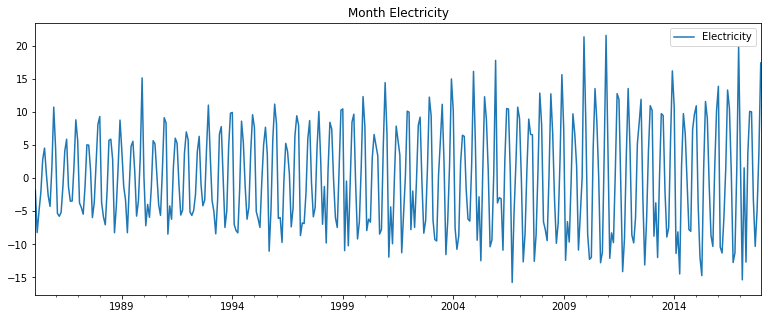

In [6]:
data_month.diff().dropna().plot(figsize=(13,5), title='Month Electricity');

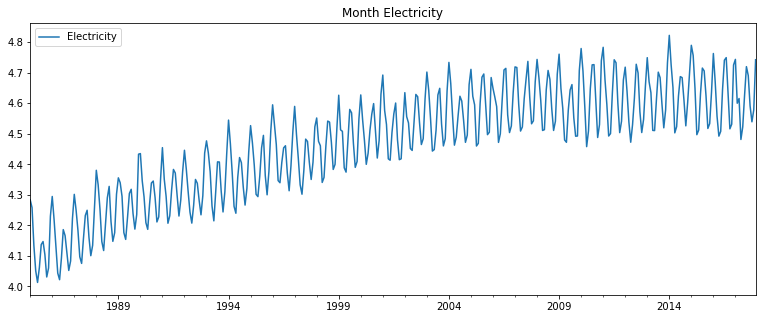

In [7]:
np.log(data_month).plot(figsize=(13,5), title='Month Electricity');

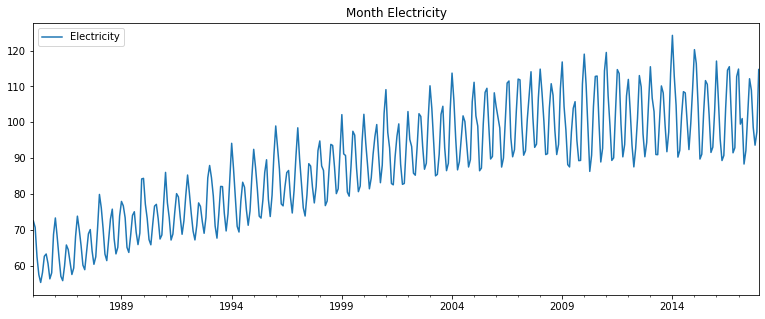

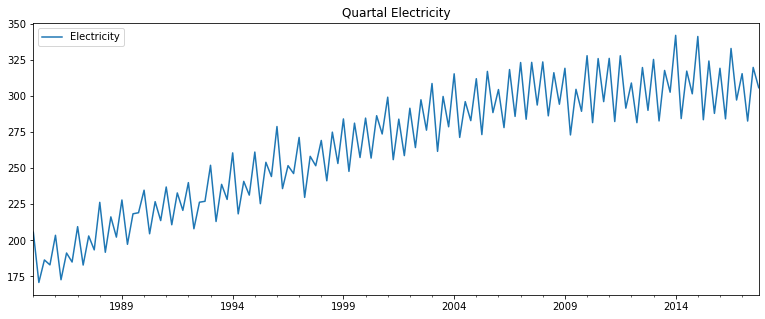

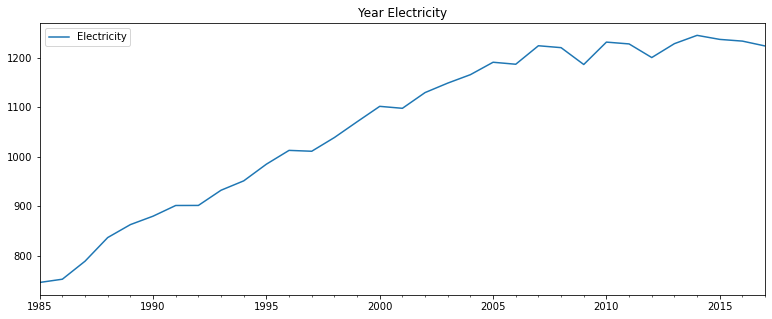

In [8]:
data_month.plot(figsize=(13,5), title='Month Electricity')
data_quartal.plot(figsize=(13,5), title='Quartal Electricity')
data_year.plot(figsize=(13,5), title='Year Electricity')
pass

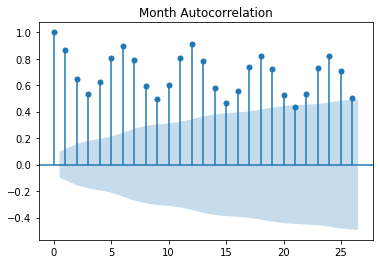

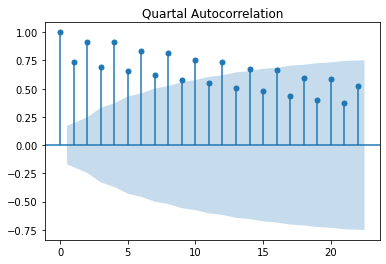

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, quarter_plot, month_plot
_ = plot_acf(data_month.Electricity, title='Month Autocorrelation')
_ = plot_acf(data_quartal.Electricity, title='Quartal Autocorrelation')

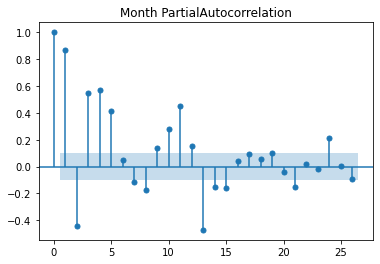

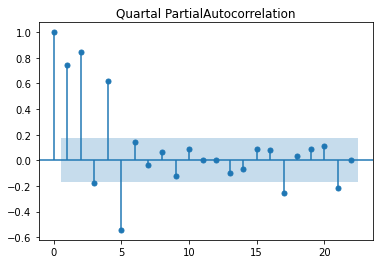

In [10]:
_ = plot_pacf(data_month.Electricity, title='Month PartialAutocorrelation')
_ = plot_pacf(data_quartal.Electricity, title='Quartal PartialAutocorrelation')

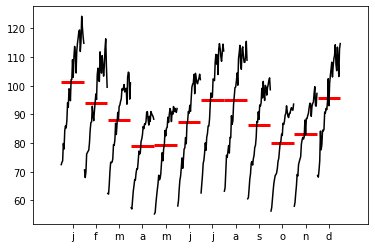

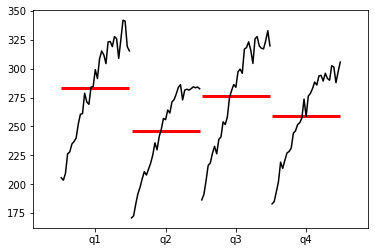

In [11]:
_ = month_plot(data_month.Electricity)
_ = quarter_plot(data_quartal.Electricity)

## Decomposition

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [13]:
def plot_curves(data, trend, season, residual):
    fig, ax = plt.subplots(4, 1, sharex=True, sharey=False)
    fig.set_figheight(10)
    fig.set_figwidth(15)

    ax[0].plot(data, label='Original')
    ax[0].legend(loc='upper left');

    ax[1].plot(trend, label='Trend')
    ax[1].legend(loc='upper left');

    ax[2].plot(season, label='Seasonality')
    ax[2].legend(loc='upper left');

    ax[3].plot(residual, label='Residuals')
    ax[3].legend(loc='upper left');
    
    
    plt.show()

##### Additive

In [14]:
decompose = seasonal_decompose(x=data_month, model='additive')
estimated_trend = decompose.trend
estimated_seasonal = decompose.seasonal
estimated_residual = decompose.resid

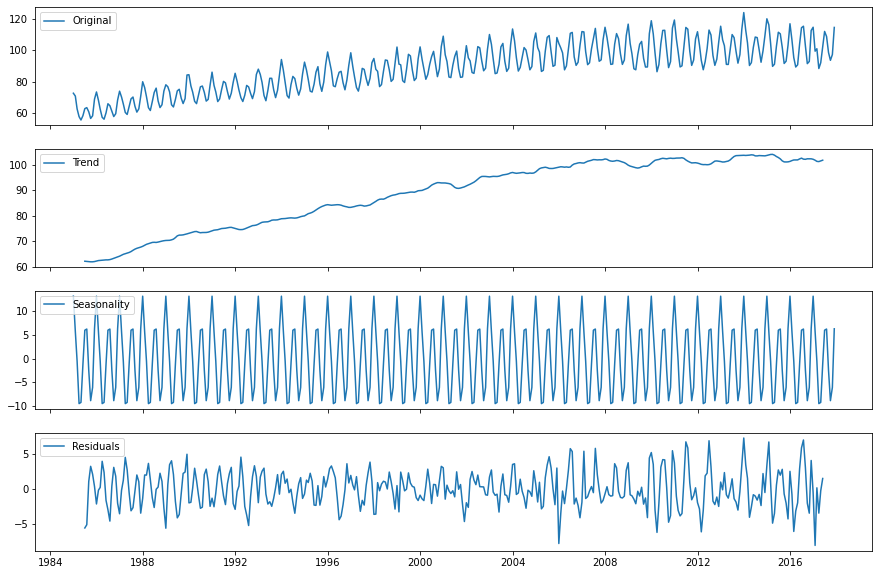

In [15]:
plot_curves(data_month, estimated_trend, estimated_seasonal, estimated_residual)

##### Multiplicative

In [16]:
decompose = seasonal_decompose(x=data_month, model='multiplicative')
estimated_trend = decompose.trend
estimated_seasonal = decompose.seasonal
estimated_residual = decompose.resid

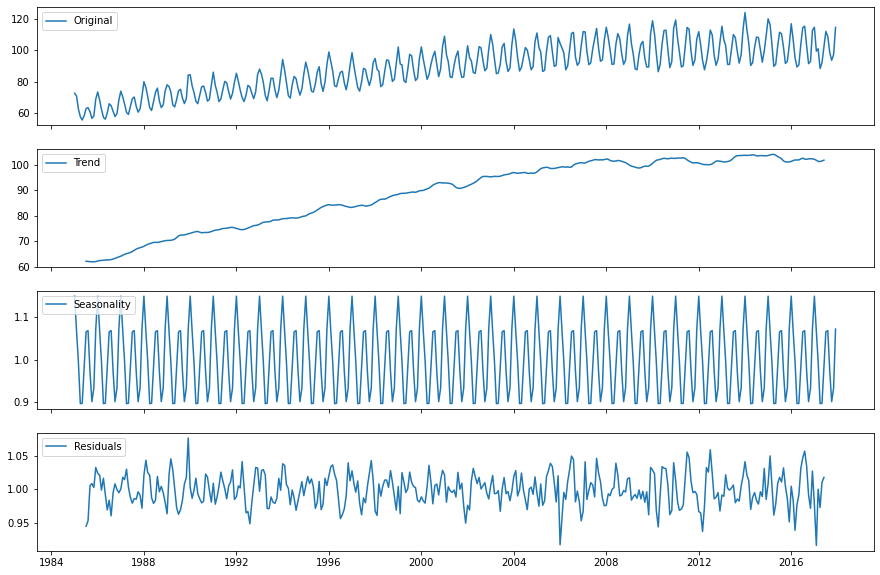

In [17]:
plot_curves(data_month, estimated_trend, estimated_seasonal, estimated_residual)

#### Stationarity

In [18]:
# check data_month on stationarity
chunks = np.array_split(data_month.Electricity.values, indices_or_sections=10)
print("{} | {:7} | {}".format("Chunk", "Mean", "Variance"))
print("-" * 26)
for i, chunk in enumerate(chunks, 1):
    print("{:5} | {:.6} | {:.6}".format(i, np.mean(chunk), np.var(chunk)))

Chunk | Mean    | Variance
--------------------------
    1 | 64.4238 | 36.5852
    2 | 72.4136 | 35.9439
    3 | 76.9748 | 41.7708
    4 | 83.8518 | 48.2514
    5 | 90.3744 | 56.3474
    6 | 94.7513 | 63.409
    7 | 100.623 | 69.4508
    8 | 100.559 | 95.0162
    9 | 102.325 | 81.3176
   10 | 102.425 | 87.8414


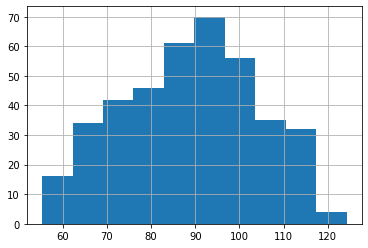

In [19]:
data_month.Electricity.hist();

In [20]:
from scipy.stats import normaltest
print(f'P-value: {normaltest(data_month.Electricity.values).pvalue}')

P-value: 4.010507729695163e-06


In [21]:
from statsmodels.tsa.stattools import adfuller
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(data_month.Electricity.values, regression='ct')
print(pvalue)

0.9382796919217558


We see that both Mean and Variance change over time, then our data with highly likely non-stationarity. Also histogram far away from normal distribution which indicates about non-stationarity too. P-value for normal test lower then 0.05 => The null hypothesis can be rejected (data from normal distribution). Regarding the adfuller test we also can not reject null hypotesis that data is stationarity.

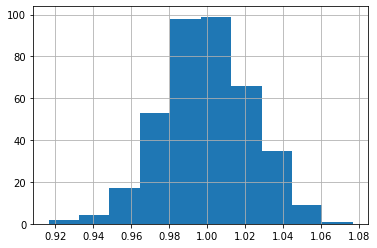

In [22]:
estimated_residual.dropna().hist();

In [23]:
from scipy.stats import normaltest
print(f'P-value: {normaltest(estimated_residual.dropna().values).pvalue}')

P-value: 0.3380012670971921


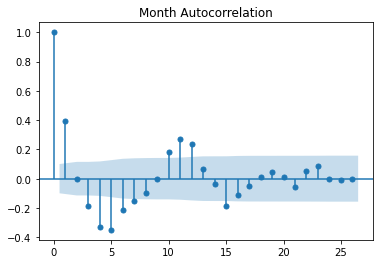

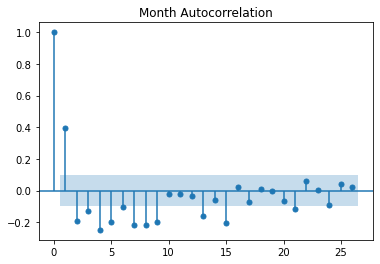

In [24]:
_ = plot_acf(estimated_residual.dropna(), title='Month Autocorrelation')
_ = plot_pacf(estimated_residual.dropna(), title='Month Autocorrelation')

In [25]:
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(estimated_residual.dropna().values, regression='ct')
print(pvalue)

3.5320667612900988e-15


And residual looks stationarity

## Smoothing

We will apply smoothing to initially data, trend, seasonality and residuals

In [26]:
def mape(y, yhat):
    return (np.abs(y - yhat) / np.abs(y)).mean()

In [27]:
def plot_smoothing(data, title, ax=None):
    if ax:
        ax.plot(data)
        ax.set_title(title)
        ax.set_xlabel('Time')
        ax.set_ylabel('Electricity')
        ax.grid(alpha=0.3)
        plt.tight_layout();
    else:
        plt.plot(data_month)
        plt.title(title)
        plt.xlabel('Time')
        plt.ylabel('Electricity')
        plt.grid(alpha=0.3);

In [28]:
decompose = seasonal_decompose(x=data_month, model='multiplicative')
trend = decompose.trend
seasonality = decompose.seasonal
residual = decompose.resid

#### Simple Smoothing

In [29]:
# simple smoothing
data_average = np.mean(data_month)
trend_average = np.mean(trend)
season_average = np.mean(seasonality)
residual_average = np.mean(residual)

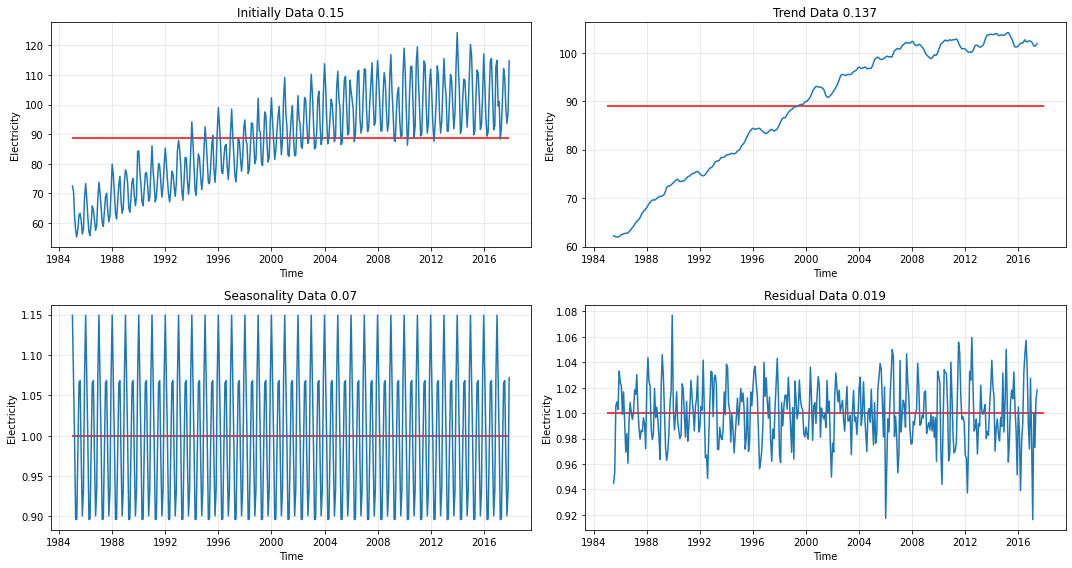

In [30]:
fig, ax = plt.subplots(2, 2, figsize=(15,8))
# init data
title = 'Initially Data ' + str(round(mape(data_month.Electricity.values, np.full(len(data_month), data_average)), 3))
plot_smoothing(data_month, title=title, ax=ax[0][0])
ax[0][0].hlines(data_average, data_month.index.min(), data_month.index.max(), color='red')
# Trend
title = 'Trend Data ' + str(round(mape(trend.dropna().values, np.full(len(trend.dropna()), trend_average)), 3))
plot_smoothing(trend, title=title, ax=ax[0][1])
ax[0][1].hlines(trend_average, trend.index.min(), trend.index.max(), color='red')
# Seasonality
title = 'Seasonality Data ' + str(round(mape(seasonality.dropna().values, np.full(len(seasonality.dropna()), season_average)), 3))
plot_smoothing(seasonality, title=title, ax=ax[1][0])
ax[1][0].hlines(season_average, seasonality.index.min(), seasonality.index.max(), color='red')
# Residual
title = 'Residual Data ' + str(round(mape(residual.dropna().values, np.full(len(residual.dropna()), residual_average)), 3))
plot_smoothing(residual, title=title, ax=ax[1][1])
ax[1][1].hlines(residual_average, residual.index.min(), residual.index.max(), color='red')
pass

#### Moving average

In [31]:
# moving average
moving_average = 3
shift_value = moving_average - 1

data_moving_average = data_month.Electricity.rolling(moving_average).mean()
trend_moving_average = trend.rolling(moving_average).mean()
season_moving_average = seasonality.rolling(moving_average).mean()
residual_moving_average = residual.rolling(moving_average).mean()

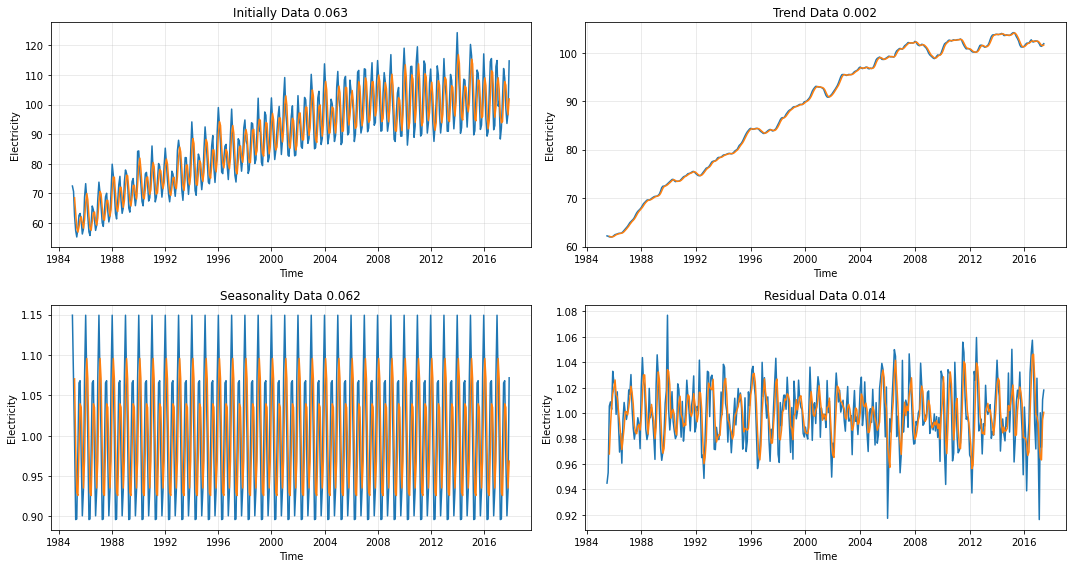

In [32]:
fig, ax = plt.subplots(2, 2, figsize=(15,8))
# init data
title = 'Initially Data ' + str(round(mape(data_month.Electricity.values[shift_value:],
                                           data_moving_average.values[shift_value:]), 3))
plot_smoothing(data_month, title='', ax=ax[0][0])
plot_smoothing(data_moving_average, title=title, ax=ax[0][0])
# Trend
title = 'Trend Data ' + str(round(mape(trend.dropna().values[shift_value:],
                                       trend_moving_average.dropna()), 3))
plot_smoothing(trend, title='', ax=ax[0][1])
plot_smoothing(trend_moving_average, title=title, ax=ax[0][1])
# Seasonality
title = 'Seasonality Data ' + str(round(mape(seasonality.dropna().values[shift_value:],
                                             season_moving_average.dropna()), 3))
plot_smoothing(seasonality, title='', ax=ax[1][0])
plot_smoothing(season_moving_average, title=title, ax=ax[1][0])
# Residual
title = 'Residual Data ' + str(round(mape(residual.dropna().values[shift_value:],
                                          residual_moving_average.dropna()), 3))
plot_smoothing(residual, title='', ax=ax[1][1])
plot_smoothing(residual_moving_average, title=title, ax=ax[1][1])
pass

#### Exponentially moving average

In [33]:
# exponentially moving average
com = 3

data_exponentially_moving_average = data_month.Electricity.ewm(com=com).mean()
trend_exponentially_moving_average = trend.dropna().ewm(com=com).mean()
season_exponentially_moving_average = seasonality.dropna().ewm(com=com).mean()
residual_exponentially_moving_average = residual.dropna().ewm(com=com).mean()

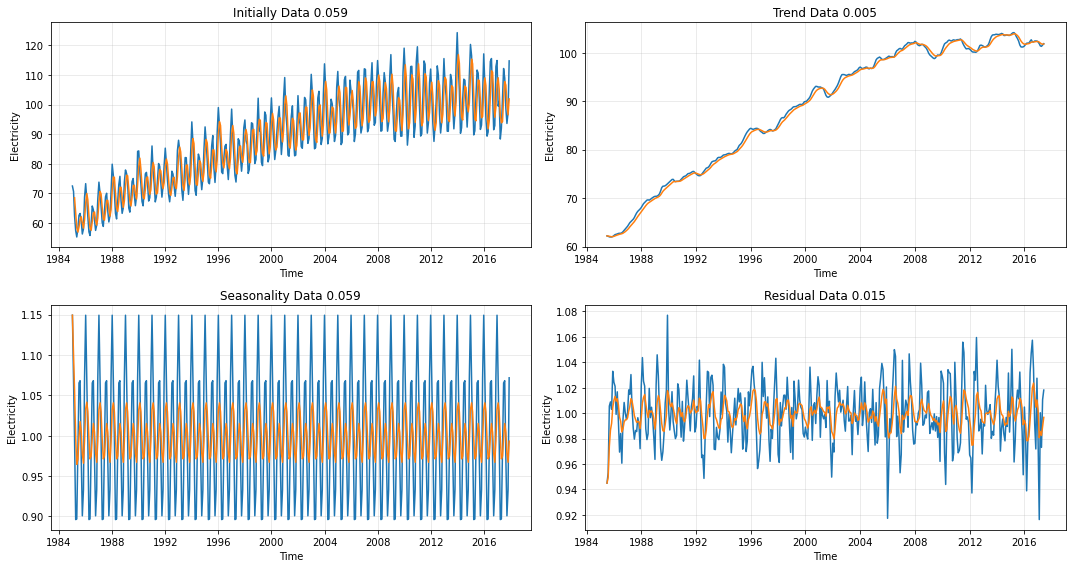

In [34]:
fig, ax = plt.subplots(2, 2, figsize=(15,8))
# init data
title = 'Initially Data ' + str(round(mape(data_month.Electricity.values, data_exponentially_moving_average), 3))
plot_smoothing(data_month, title=title, ax=ax[0][0])
plot_smoothing(data_moving_average, title=title, ax=ax[0][0])
# Trend
title = 'Trend Data ' + str(round(mape(trend.dropna().values, trend_exponentially_moving_average.dropna()), 3))
plot_smoothing(trend, title=title, ax=ax[0][1])
plot_smoothing(trend_exponentially_moving_average, title=title, ax=ax[0][1])
# Seasonality
title = 'Seasonality Data ' + str(round(mape(seasonality.dropna().values, season_exponentially_moving_average.dropna()), 3))
plot_smoothing(seasonality, title=title, ax=ax[1][0])
plot_smoothing(season_exponentially_moving_average, title=title, ax=ax[1][0])
# Residual
title = 'Residual Data ' + str(round(mape(residual.dropna().values, residual_exponentially_moving_average), 3))
plot_smoothing(residual, title=title, ax=ax[1][1])
plot_smoothing(residual_exponentially_moving_average, title=title, ax=ax[1][1])
pass

## Predict with smoothing

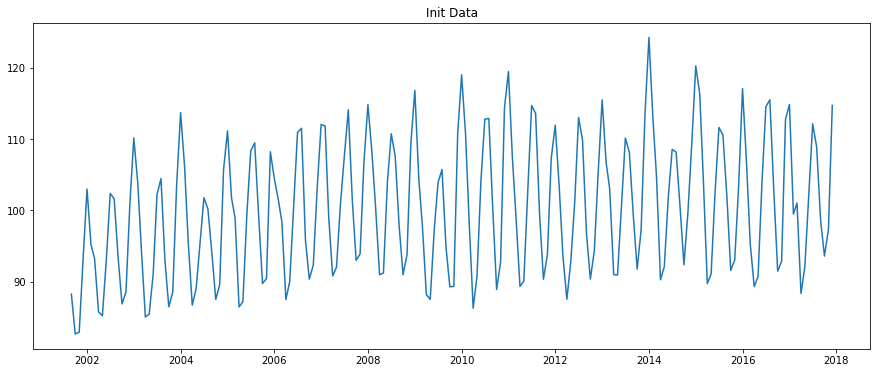

In [35]:
plt.figure(figsize=(15,6))
plt.plot(data_month[200:])
plt.title('Init Data');

In [36]:
train = data_month[:-6]
test = data_month[-6:]
train.index = pd.DatetimeIndex(train.index.values,
                               freq=train.index.inferred_freq)

In [37]:
# simple exp smoothing
from statsmodels.tsa.api import SimpleExpSmoothing
single = SimpleExpSmoothing(train).fit(optimized=True)

single_preds = single.forecast(len(test))
single_mape = mape(test.Electricity.values, single_preds)
print(f'Single MAPE: {single_mape}')

Single MAPE: 0.07292179685054441


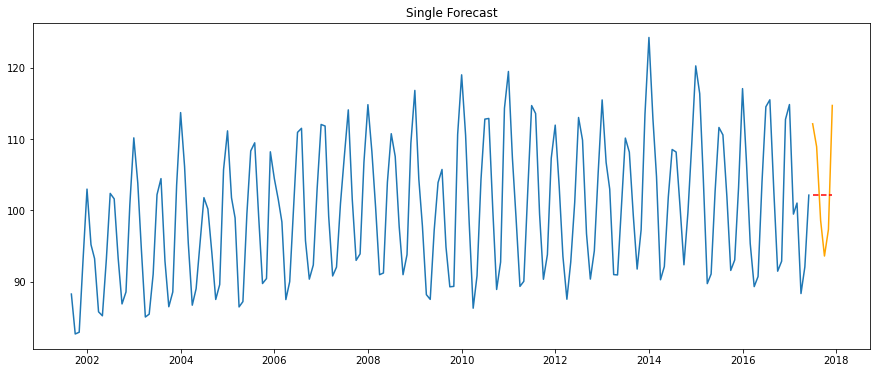

In [38]:
plt.figure(figsize=(15,6))
plt.plot(train.index[200:], train[200:], label="train")
plt.plot(test.index, test, color='orange', label="test")
plt.plot(test.index, single_preds, 'r--', label="predictions")
plt.title('Single Forecast');

In [39]:
# double exp smoothing
from statsmodels.tsa.api import Holt
double = Holt(train).fit(optimized=True)

double_preds = double.forecast(len(test))
double_mape = mape(test.Electricity.values, double_preds)
print(f'Double MAPE: {double_mape}')

Double MAPE: 0.07353784819088137


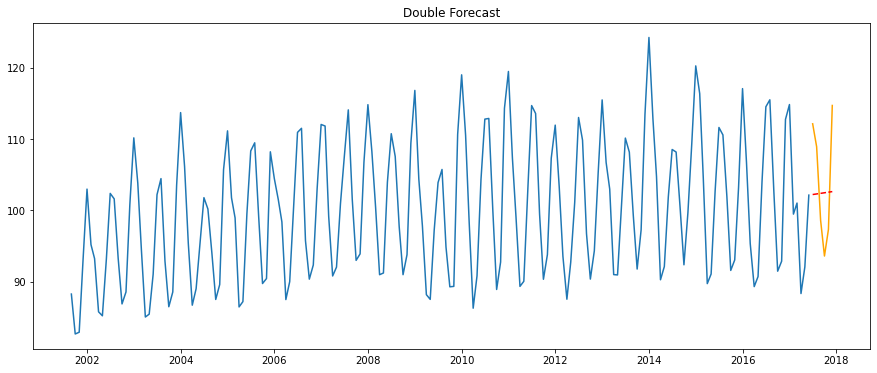

In [40]:
plt.figure(figsize=(15,6))
plt.plot(train.index[200:], train[200:], label="train")
plt.plot(test.index, test, color='orange', label="test")
plt.plot(test.index, double_preds, 'r--', label="predictions")
plt.title('Double Forecast');

In [41]:
from statsmodels.tsa.api import ExponentialSmoothing
triple = ExponentialSmoothing(train,
                              trend="multiplicative",
                              seasonal="additive",
                              seasonal_periods=12).fit(optimized=True)
triple_preds = triple.forecast(len(test))
triple_mape = mape(test.Electricity.values, triple_preds)
print(f'Double MAPE: {triple_mape}');

Double MAPE: 0.024447215138693298


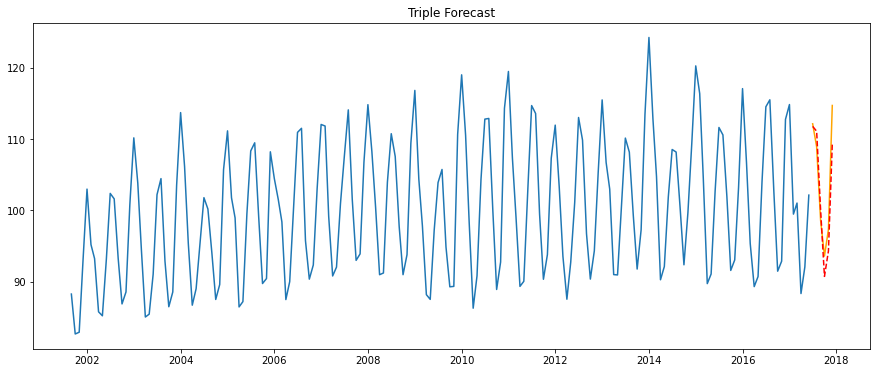

In [42]:
plt.figure(figsize=(15,6))
plt.plot(train.index[200:], train[200:], label="train")
plt.plot(test.index, test, color='orange', label="test")
plt.plot(test.index, triple_preds, 'r--', label="predictions")
plt.title('Triple Forecast');

## Preidct with models

#### Stationarity

In [43]:
data = np.log(data_month).diff().dropna()
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(data.values, regression='ct')
print(pvalue)

7.853727031199286e-10


In [44]:
# check data_month on stationarity
chunks = np.array_split(data.Electricity.values, indices_or_sections=10)
print("{} | {:7} | {}".format("Chunk", "Mean", "Variance"))
print("-" * 26)
for i, chunk in enumerate(chunks, 1):
    print("{:5} | {:.6} | {:.6}".format(i, np.mean(chunk), np.var(chunk)))

Chunk | Mean    | Variance
--------------------------
    1 | -0.00415356 | 0.0058156
    2 | 0.0045195 | 0.00590786
    3 | 0.00571017 | 0.00602199
    4 | -0.00424013 | 0.00590183
    5 | 0.00308569 | 0.00690692
    6 | 0.00462381 | 0.00669371
    7 | -0.00131557 | 0.00723531
    8 | 0.000600953 | 0.00951227
    9 | -0.000606417 | 0.00757837
   10 | 0.00341465 | 0.00906368


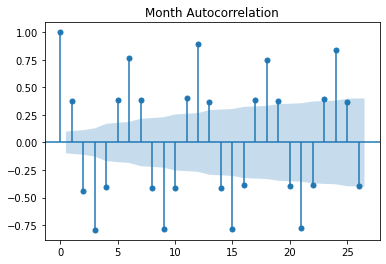

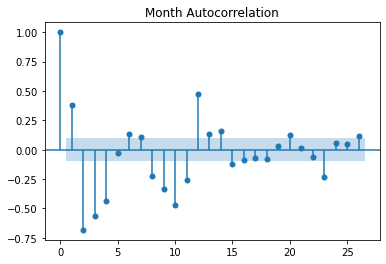

In [45]:
_ = plot_acf(data.Electricity, title='Month Autocorrelation')
_ = plot_pacf(data.Electricity, title='Month Autocorrelation')

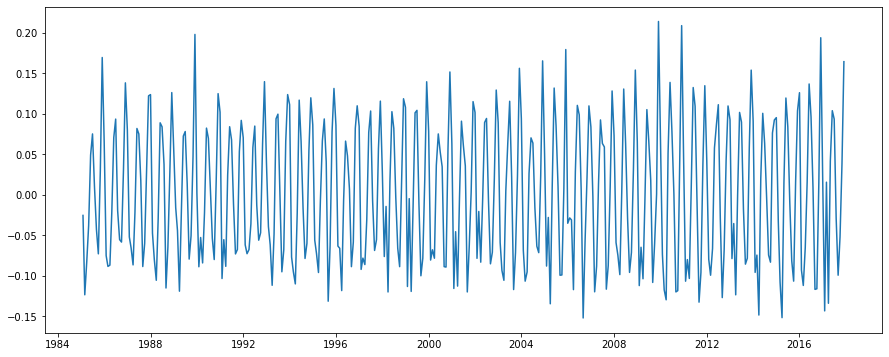

In [46]:
plt.figure(figsize=(15,6))
plt.plot(data);

In [47]:
import statsmodels.api as sm

In [48]:
decompose = seasonal_decompose(x=data_month, model='multiplicative')
residual = decompose.resid.dropna()
residual = pd.DataFrame(data=residual.values, index=residual.index, columns=['Electricity'])

In [49]:
train = data_month[:-36]
test = data_month[-36:]

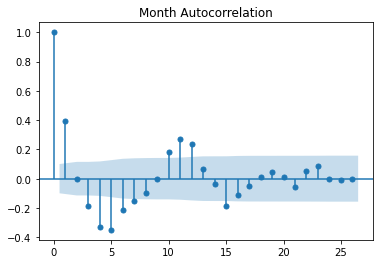

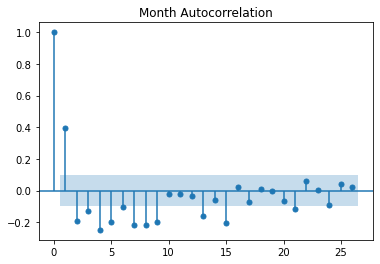

In [50]:
_ = plot_acf(residual.Electricity, title='Month Autocorrelation')
_ = plot_pacf(residual.Electricity, title='Month Autocorrelation')

In [51]:
len(train), len(test)

(360, 36)

#### AR

In [52]:
model = sm.tsa.ARMA(train, (9, 0)).fit()
preds = model.predict(len(train), len(train) + len(test)-1)
model.params

const                85.425257
ar.L1.Electricity     0.971975
ar.L2.Electricity    -0.392917
ar.L3.Electricity    -0.008495
ar.L4.Electricity     0.000043
ar.L5.Electricity     0.337148
ar.L6.Electricity     0.071581
ar.L7.Electricity     0.113493
ar.L8.Electricity    -0.296692
ar.L9.Electricity     0.193933
dtype: float64

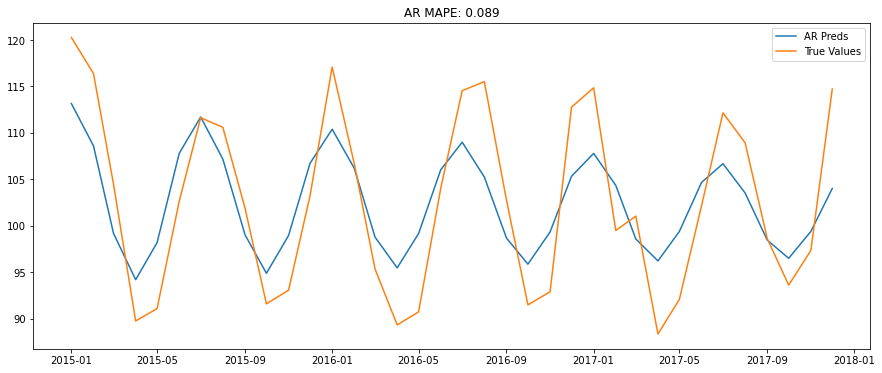

In [53]:
plt.figure(figsize=(15,6))
plt.plot(preds, label='AR Preds')
plt.plot(test, label='True Values')
plt.title(f'AR MAPE: {round(mape(preds.values, test.values), 3)}')
plt.legend()
pass

#### MA

In [54]:
model = sm.tsa.ARMA(train, (0, 4)).fit()
preds = model.predict(len(train), len(train) + len(test)-1)
model.params

const                87.410889
ma.L1.Electricity     1.585387
ma.L2.Electricity     1.573898
ma.L3.Electricity     1.038831
ma.L4.Electricity     0.303675
dtype: float64

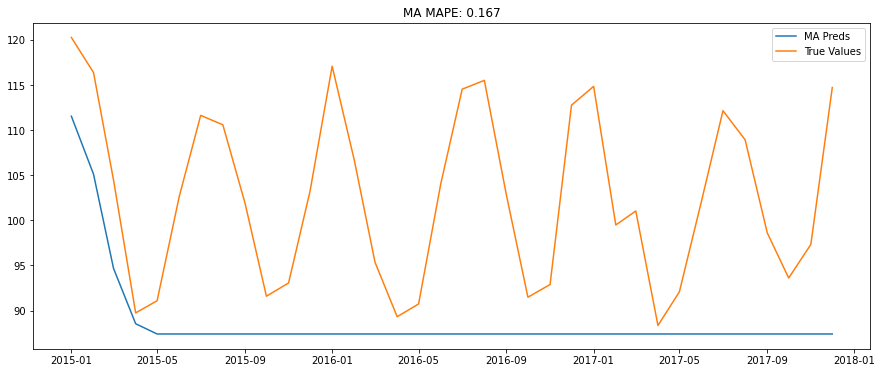

In [55]:
plt.figure(figsize=(15,6))
plt.plot(preds, label='MA Preds')
plt.plot(test, label='True Values')
plt.title(f'MA MAPE: {round(mape(preds.values, test.values), 3)}')
plt.legend()
pass

#### SARIMA

In [56]:
train = data_month.dropna()[:-36]
test = data_month.dropna()[-36:]

In [57]:
sar = sm.tsa.statespace.SARIMAX(train.Electricity, 
                                order=(2,1,0),
                                seasonal_order=(0,1,1,12),
                                trend='n').fit()
sar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                          Electricity   No. Observations:                  360
Model:             SARIMAX(2, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -800.547
Date:                              Fri, 26 Feb 2021   AIC                           1609.095
Time:                                      10:15:14   BIC                           1624.492
Sample:                                  01-01-1985   HQIC                          1615.225
                                       - 12-01-2014                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2356      0.050     -4.718      0.000      -0.334      -0.138
ar.L2         -0.2435      0.054     -4.489      0.000      -0.350      -0.137
ma.S.L12      -0.7004      0.039    -17.912      0.000      -0.777      -0.624
sigma2         5.7687      0.367     15.732      0.000       5.050       6.487
===================================================================================
Ljung-Box (L1) (Q):                   0.27   Jarque-Bera (JB):                17.68
Prob(Q):                              0.61   Prob(JB):                         0.00
Heteroskedasticity (H):               2.71   Skew:                            -0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

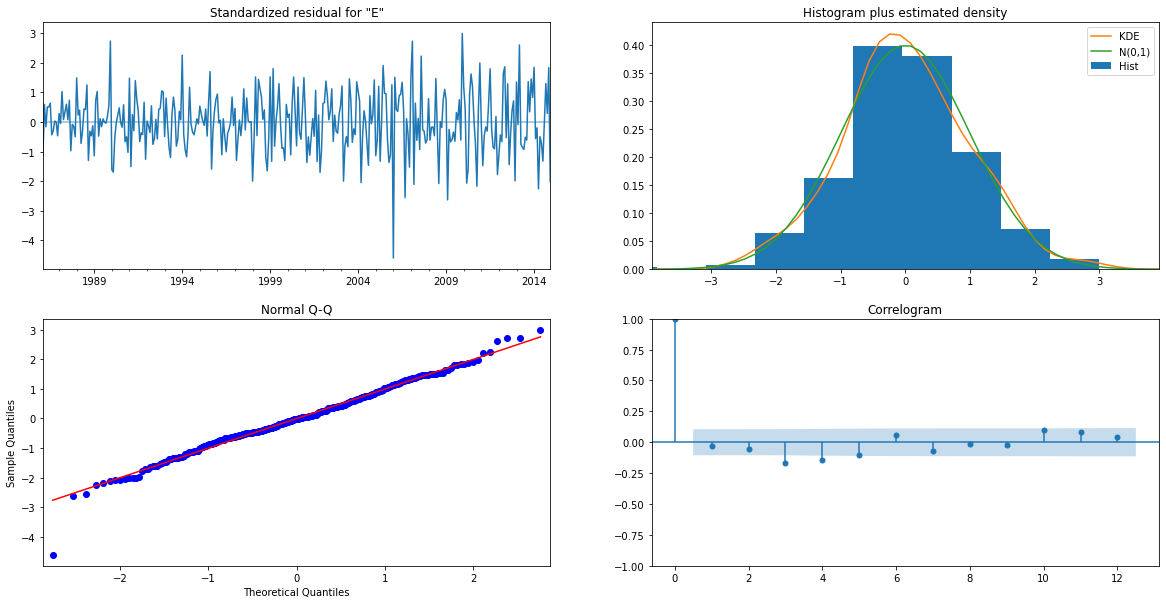

In [58]:
sar.plot_diagnostics(lags=12, figsize = (20,10));

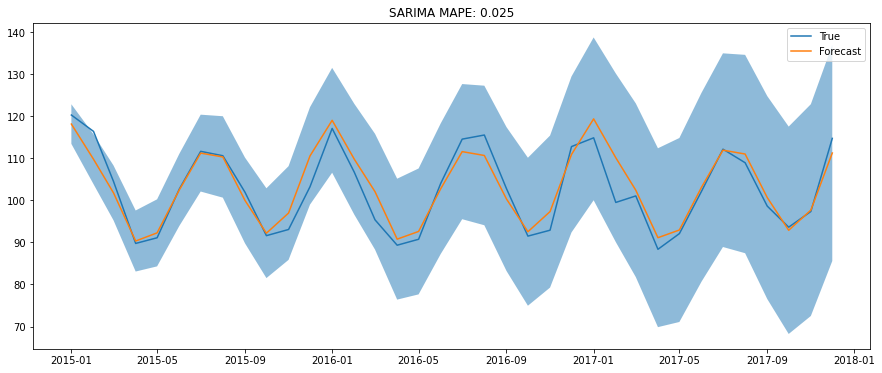

In [59]:
plt.figure(figsize=(15,6))
test['forecast'] = sar.predict(start = len(train)-1, end= len(train)- 1 + len(test)) 
feature_forecast = sar.get_forecast(36)
confidence_int = feature_forecast.conf_int(alpha = 0.05)

plt.plot(test.Electricity, label='True')
plt.plot(test.forecast, label='Forecast')
plt.title(f'SARIMA MAPE: {round(mape(test.dropna().Electricity.values, test.dropna().forecast.values), 3)}')
plt.fill_between(confidence_int.index, confidence_int['lower Electricity'],confidence_int['upper Electricity'],alpha=0.5)
plt.legend()
pass

#### AutoARIMA

In [60]:
%%time
stepwise_model = pm.auto_arima(train.Electricity,
                               start_p=1,
                               start_q=1,
                               start_d=1,
                               max_p=6,
                               max_q=6,
                               max_d=2,
                               m=12,
                               start_P=0,
                               start_D=0,
                               start_Q=0,
                               max_P=5,
                               max_D=2,
                               max_Q=5,
                               seasonal=True,
                               trace=False,
                               error_action='ignore', 
                               suppress_warnings=True, 
                               stepwise=True)
print(stepwise_model.aic())

1636.9988146412384
Wall time: 1min 40s


In [61]:
stepwise_model

ARIMA(order=(1, 1, 2), scoring_args={}, seasonal_order=(3, 0, 1, 12),
      suppress_warnings=True, with_intercept=False)

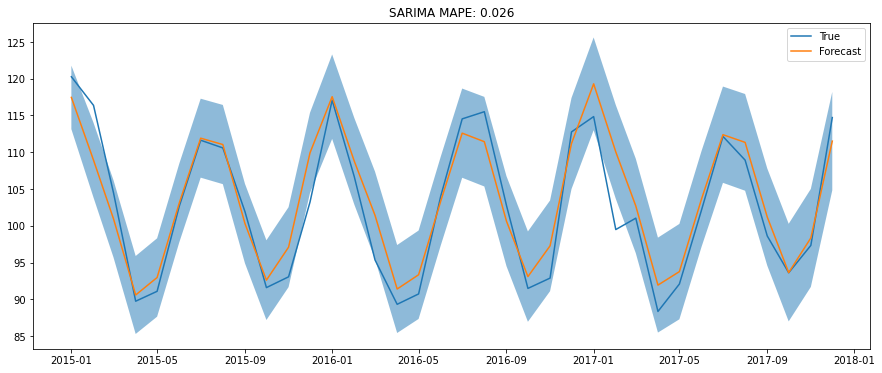

In [62]:
plt.figure(figsize=(15,6))
preds = stepwise_model.predict(36, return_conf_int=True, alpha=0.05)
test['forecast'] = preds[0]
test['lower Electricity'] = preds[1][:,0]
test['upper Electricity'] = preds[1][:,1]


plt.plot(test.Electricity, label='True')
plt.plot(test.forecast, label='Forecast')
plt.title(f'SARIMA MAPE: {round(mape(test.dropna().Electricity.values, test.dropna().forecast.values), 3)}')
plt.fill_between(test.index, test['lower Electricity'], test['upper Electricity'],alpha=0.5)
plt.legend()
pass

#### How many month do we need

In [63]:
from sklearn.metrics import mean_squared_error

2


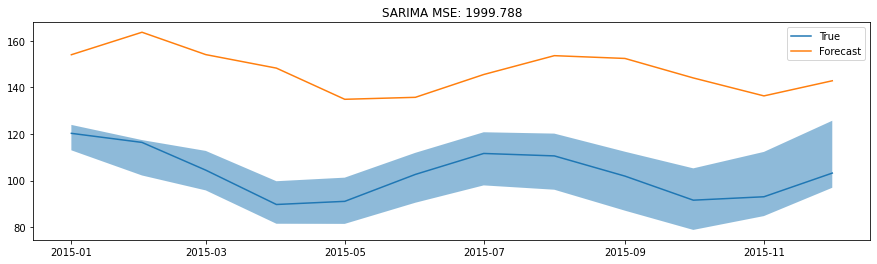

3


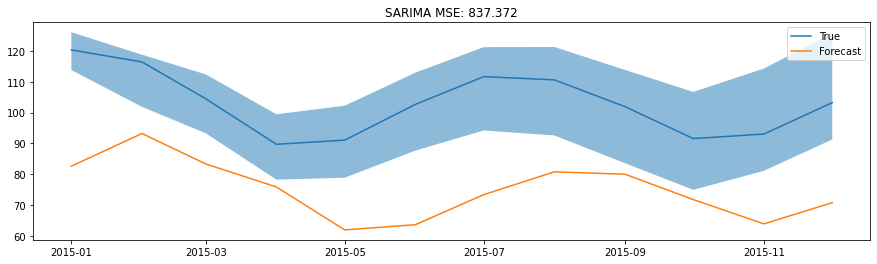

4


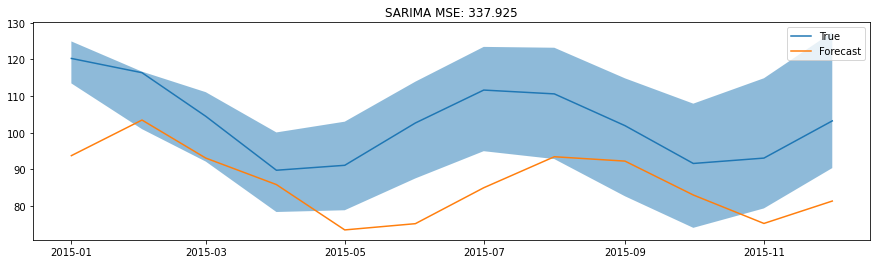

5


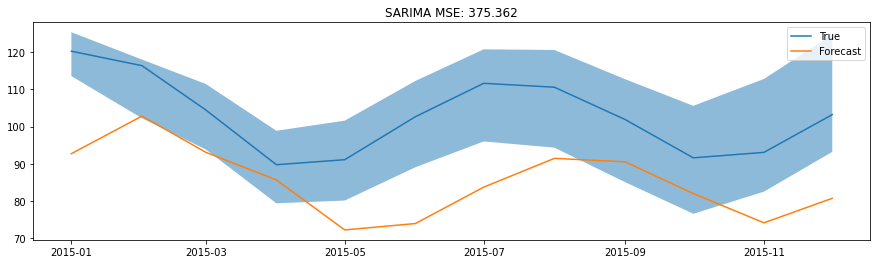

6


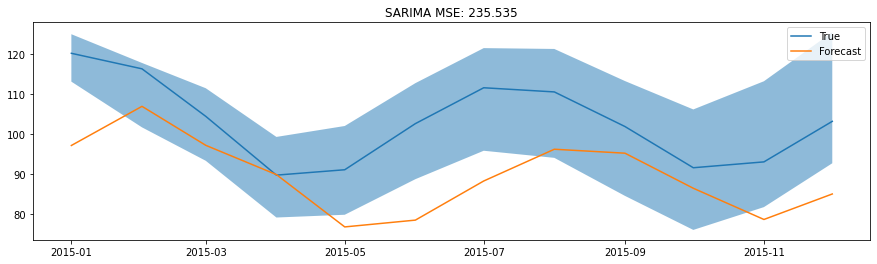

7


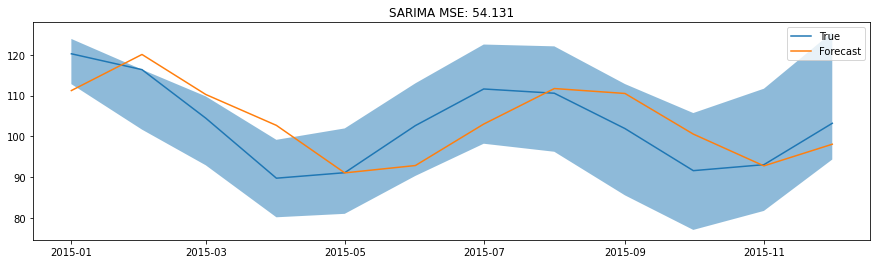

8


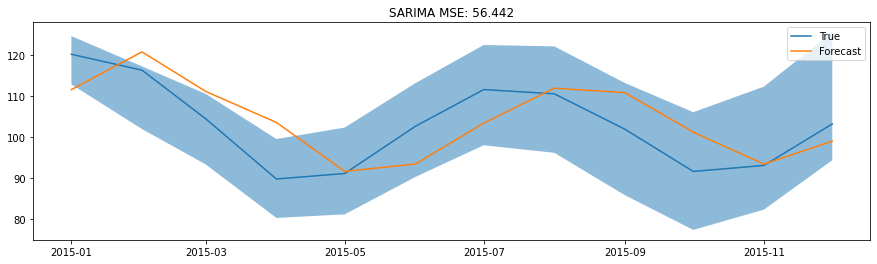

9


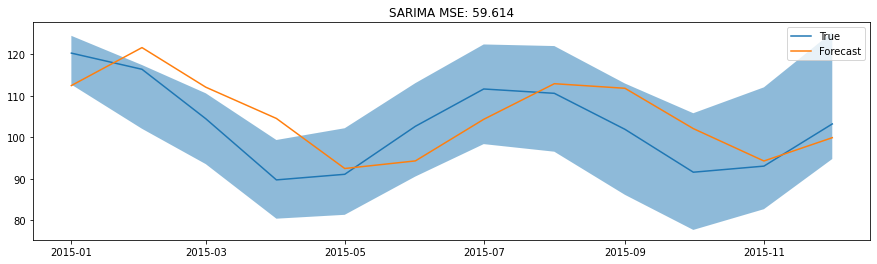

10


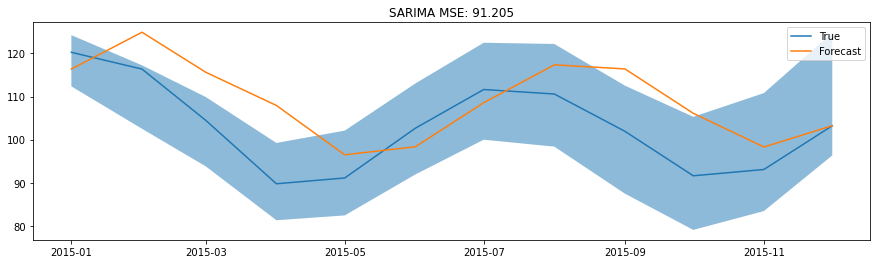

11


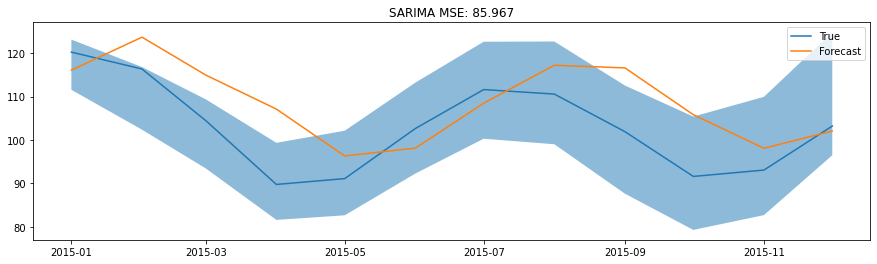

12


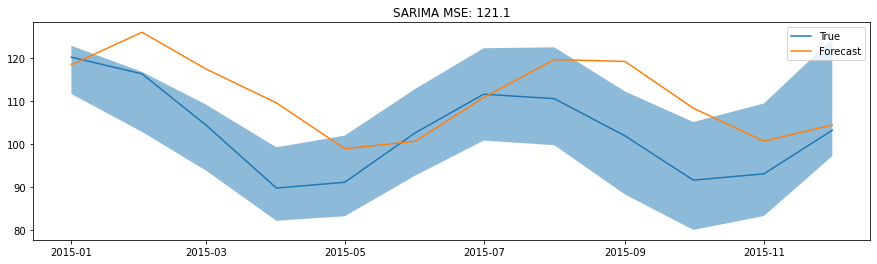

13


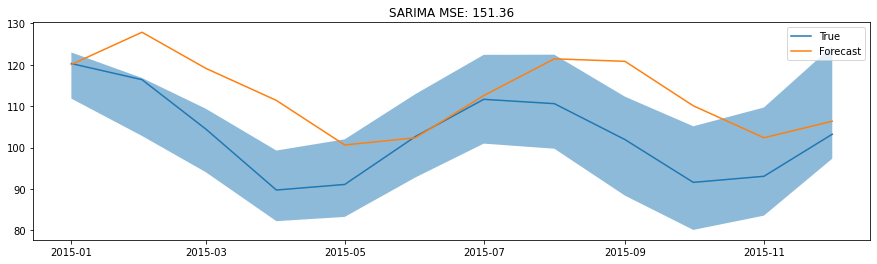

14


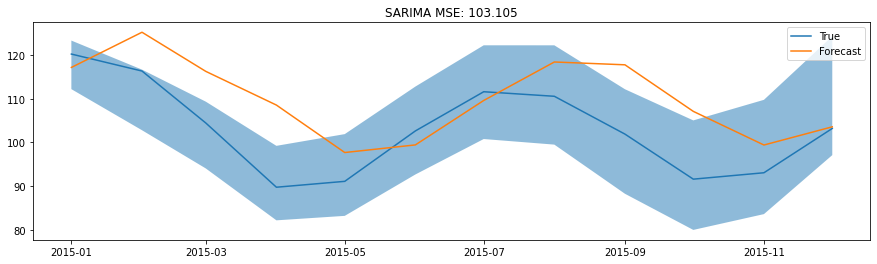

15


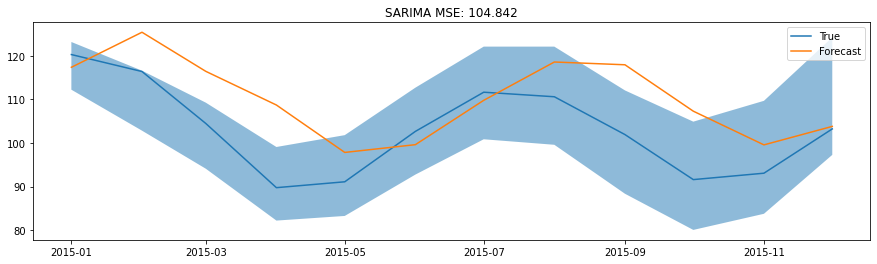

16


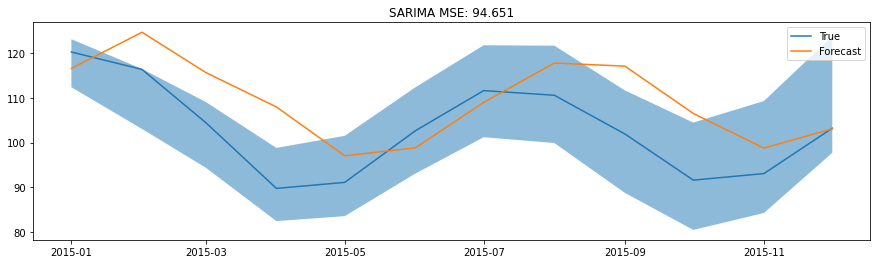

17


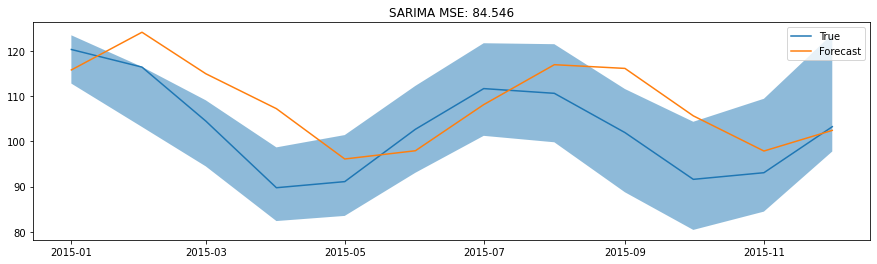

18


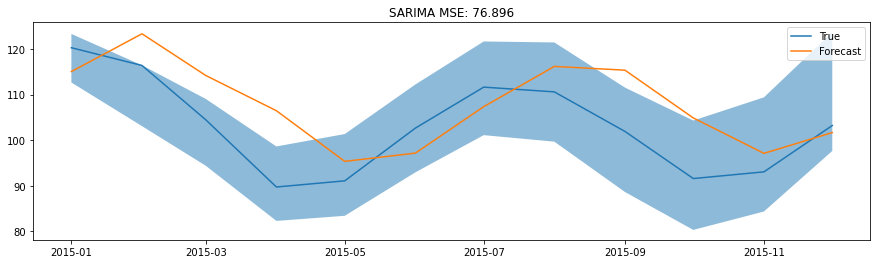

19


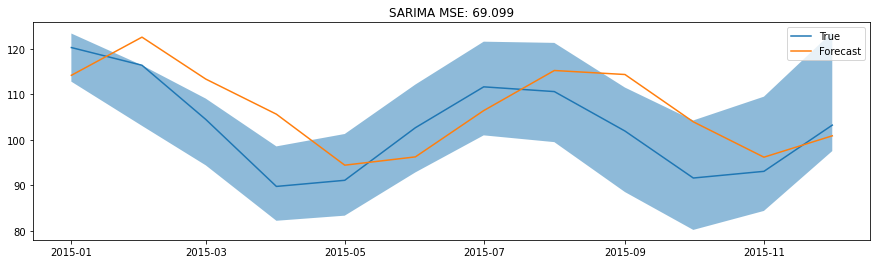

In [64]:
# one month
test_temp = test[:12]

for year in range(2, 20):
    print(year)
    sar = sm.tsa.statespace.SARIMAX(train[-year*12:].Electricity, 
                                    order=(2,1,0),
                                    seasonal_order=(0,1,1,12),
                                    trend='n').fit()
    plt.figure(figsize=(15,4))
    test_temp['forecast'] = sar.predict(start = len(train)-1, end= len(train)- 2 + len(test_temp)).values
    feature_forecast = sar.get_forecast(12)
    confidence_int = feature_forecast.conf_int(alpha = 0.05)

    plt.plot(test_temp.Electricity, label='True')
    plt.plot(test_temp.forecast, label='Forecast')
    plt.title(f'SARIMA MSE: {round(mean_squared_error(test_temp.dropna().Electricity.values, test_temp.dropna().forecast.values), 3)}')
    plt.fill_between(confidence_int.index, confidence_int['lower Electricity'],confidence_int['upper Electricity'],alpha=0.5)
    plt.legend()
    plt.show()

2


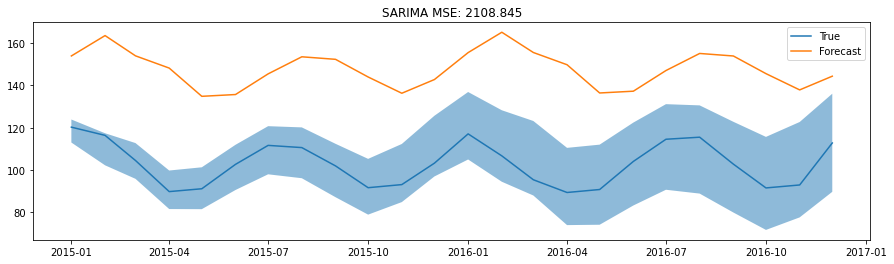

3


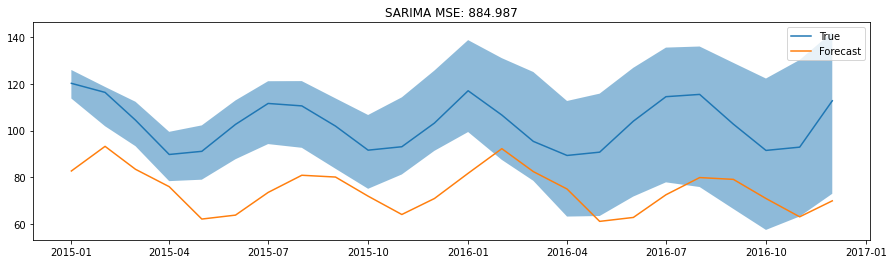

4


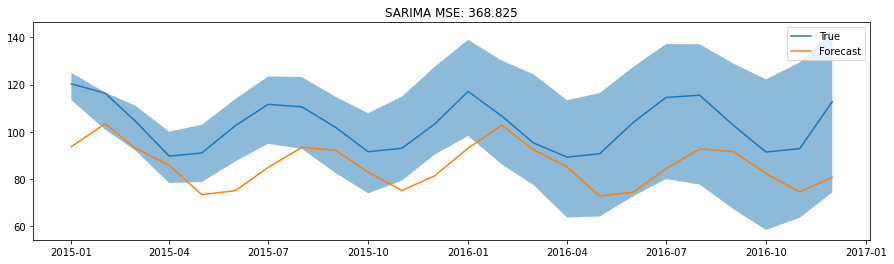

5


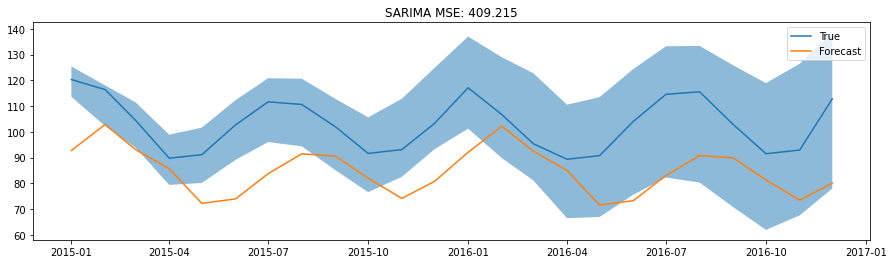

6


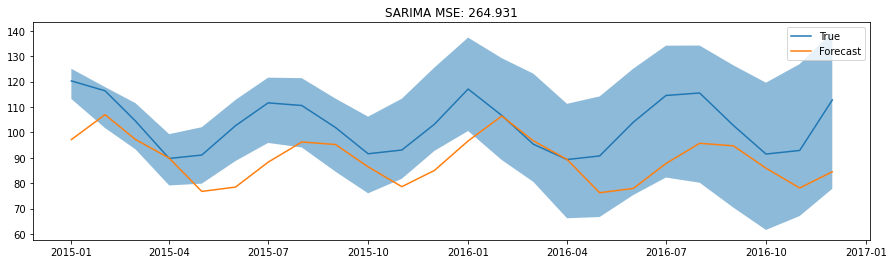

7


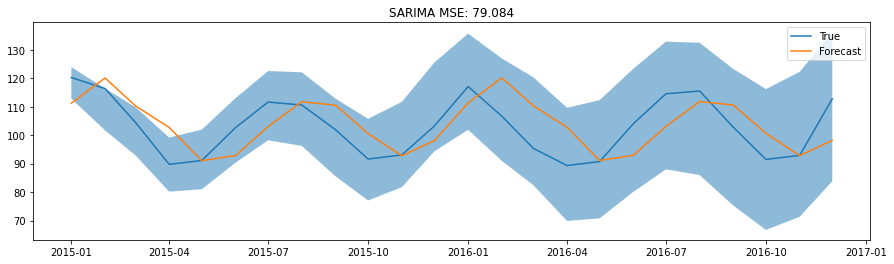

8


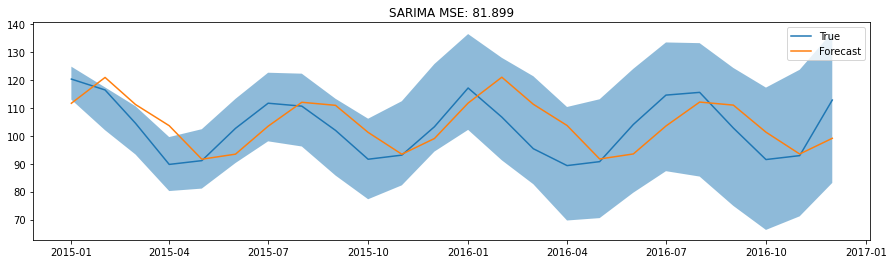

9


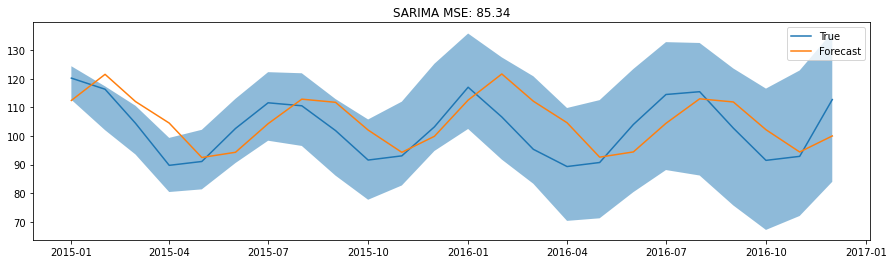

10


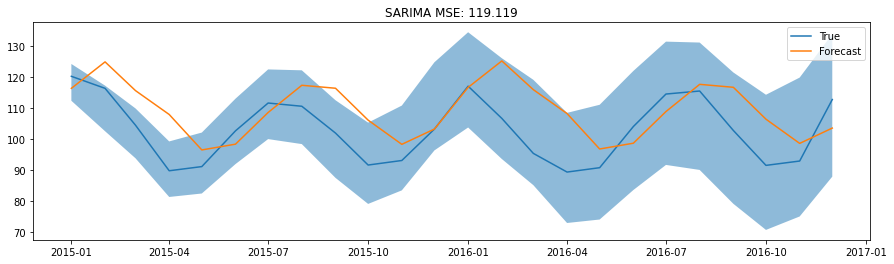

11


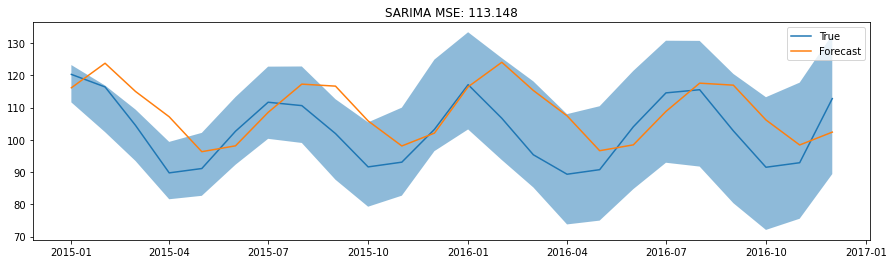

12


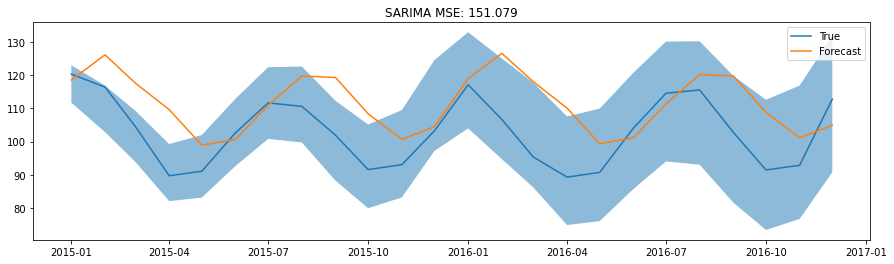

13


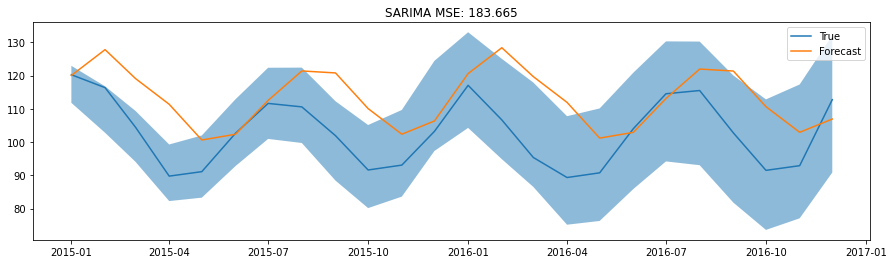

14


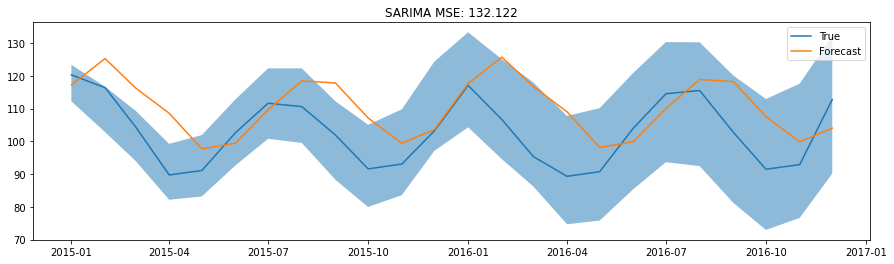

15


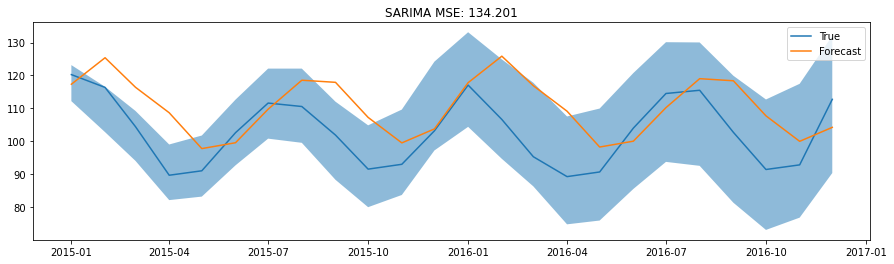

16


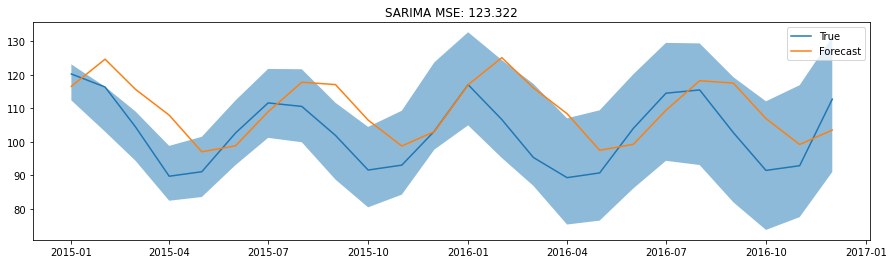

17


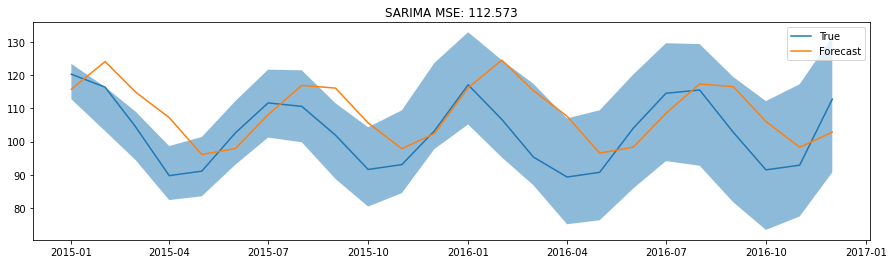

18


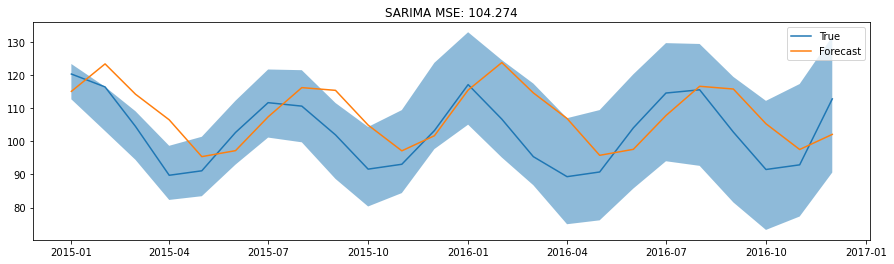

19


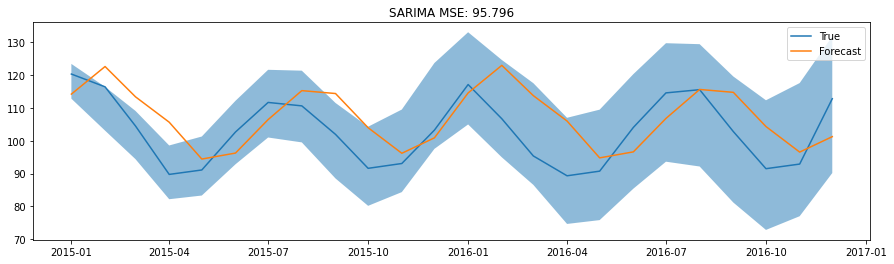

In [65]:
# two month
test_temp = test[:24]

for year in range(2, 20):
    print(year)
    sar = sm.tsa.statespace.SARIMAX(train[-year*12:].Electricity, 
                                    order=(2,1,0),
                                    seasonal_order=(0,1,1,12),
                                    trend='n').fit()
    plt.figure(figsize=(15,4))
    test_temp['forecast'] = sar.predict(start = len(train)-1, end= len(train)- 2 + len(test_temp)).values
    feature_forecast = sar.get_forecast(24)
    confidence_int = feature_forecast.conf_int(alpha = 0.05)

    plt.plot(test_temp.Electricity, label='True')
    plt.plot(test_temp.forecast, label='Forecast')
    plt.title(f'SARIMA MSE: {round(mean_squared_error(test_temp.dropna().Electricity.values, test_temp.dropna().forecast.values), 3)}')
    plt.fill_between(confidence_int.index, confidence_int['lower Electricity'],confidence_int['upper Electricity'],alpha=0.5)
    plt.legend()
    plt.show()

2


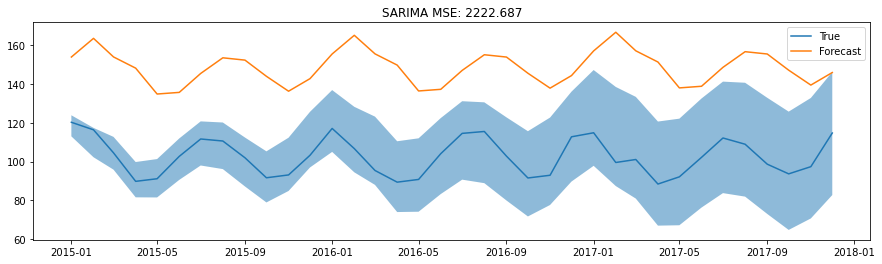

3


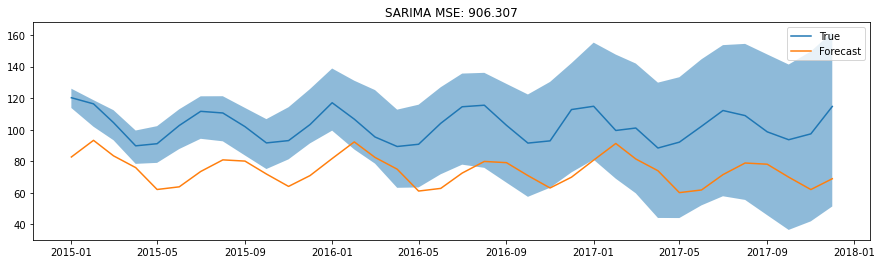

4


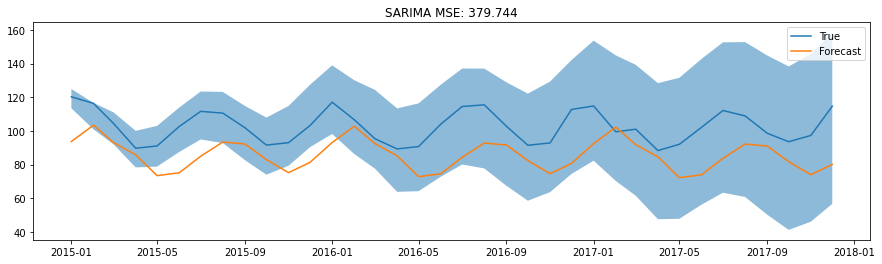

5


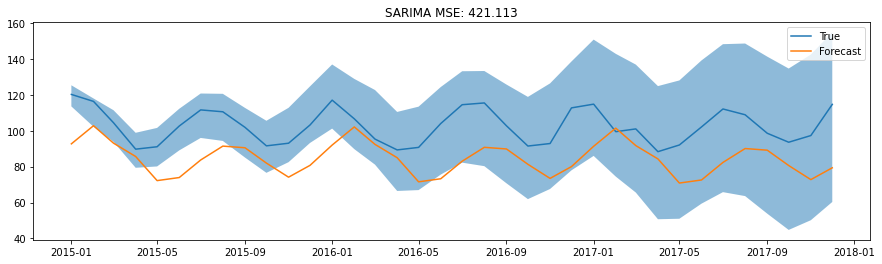

6


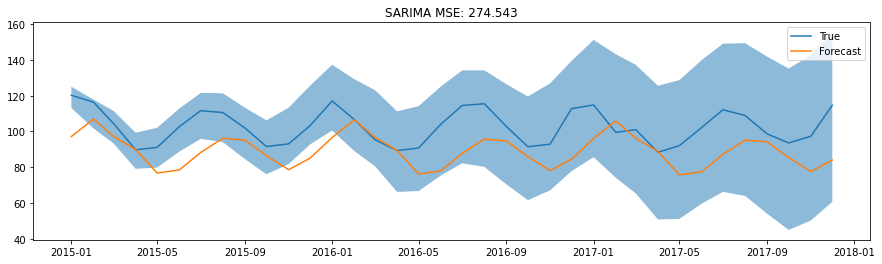

7


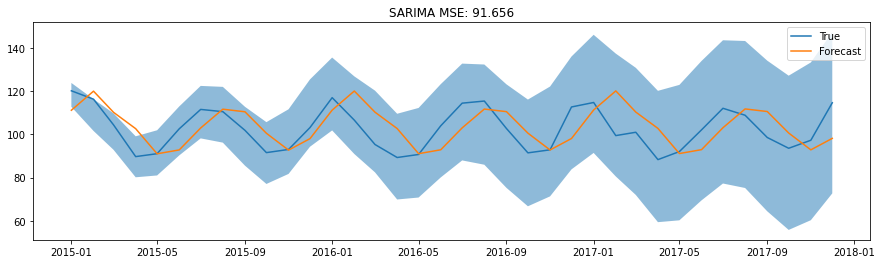

8


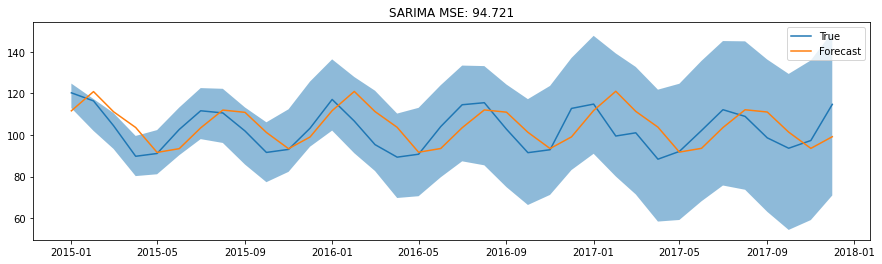

9


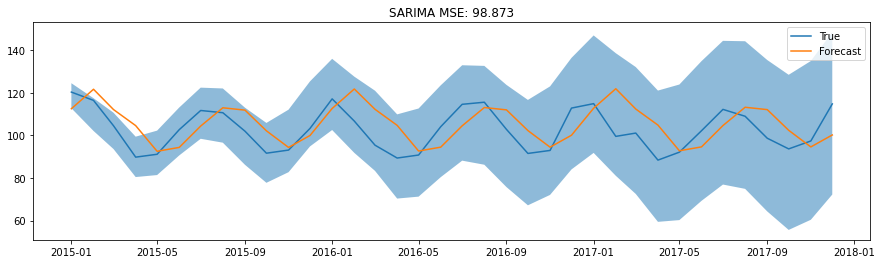

10


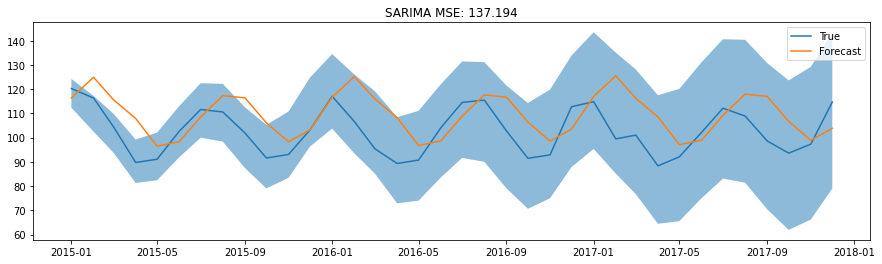

11


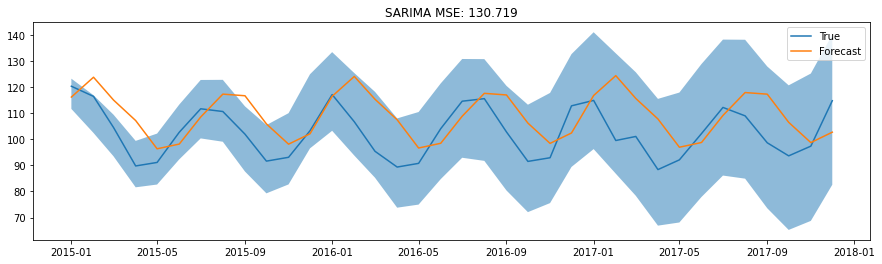

12


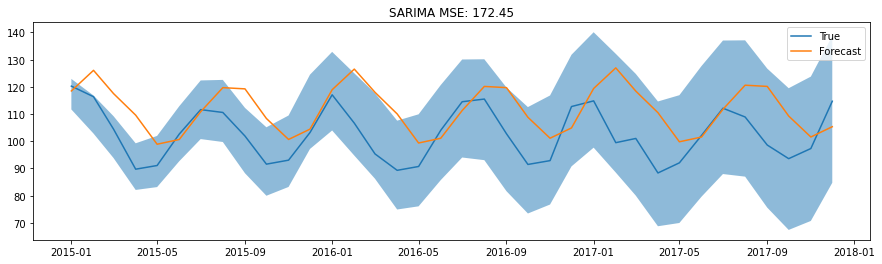

13


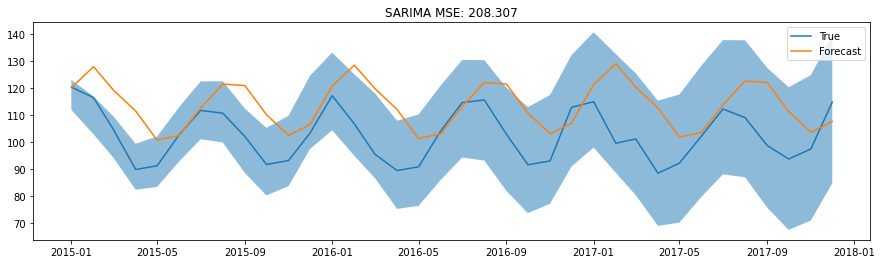

14


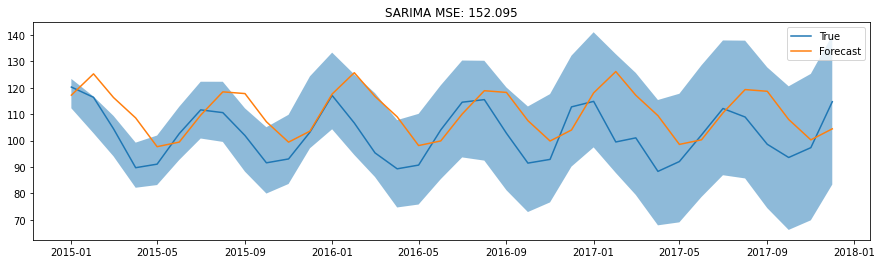

15


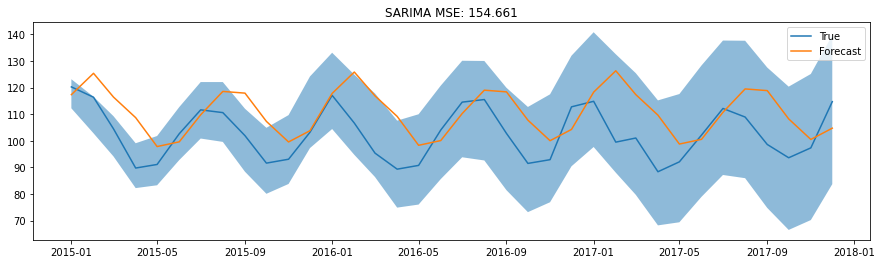

16


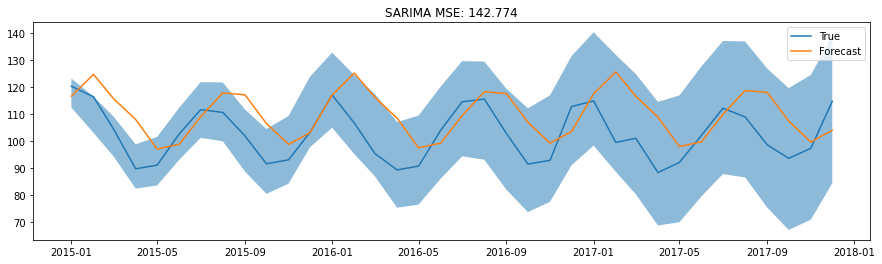

17


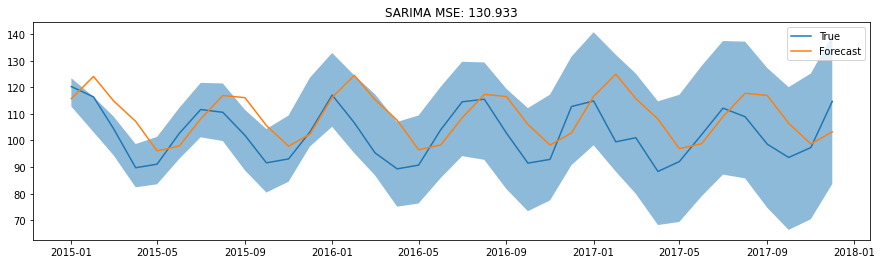

18


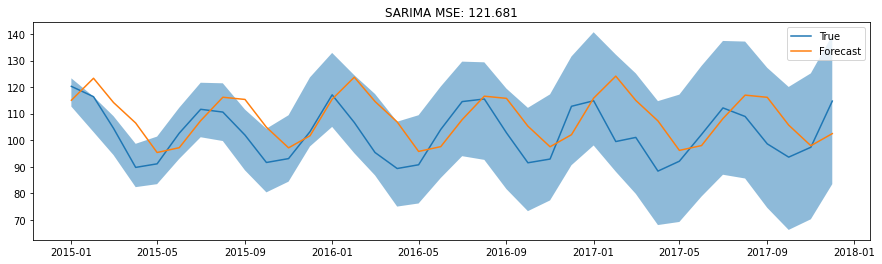

19


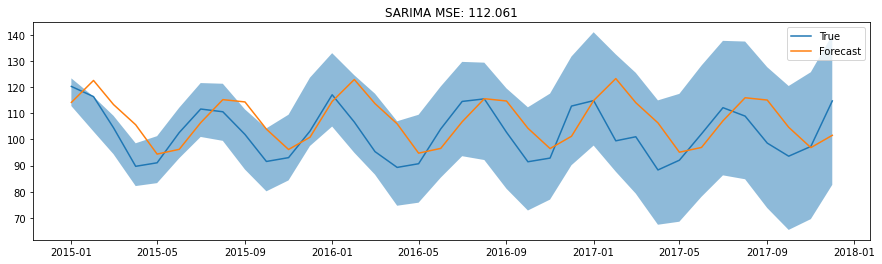

In [66]:
# three month
test_temp = test.copy()

for year in range(2, 20):
    print(year)
    sar = sm.tsa.statespace.SARIMAX(train[-year*12:].Electricity, 
                                    order=(2,1,0),
                                    seasonal_order=(0,1,1,12),
                                    trend='n').fit()
    plt.figure(figsize=(15,4))
    test_temp['forecast'] = sar.predict(start = len(train)-1, end= len(train)- 2 + len(test_temp)).values
    feature_forecast = sar.get_forecast(36)
    confidence_int = feature_forecast.conf_int(alpha = 0.05)

    plt.plot(test_temp.Electricity, label='True')
    plt.plot(test_temp.forecast, label='Forecast')
    plt.title(f'SARIMA MSE: {round(mean_squared_error(test_temp.dropna().Electricity.values, test_temp.dropna().forecast.values), 3)}')
    plt.fill_between(confidence_int.index, confidence_int['lower Electricity'],confidence_int['upper Electricity'],alpha=0.5)
    plt.legend()
    plt.show()

## Prophet

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pmdarima as pm
from warnings import filterwarnings
filterwarnings('ignore')
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error

In [68]:
def mape(y, yhat):
    return (np.abs(y - yhat) / np.abs(y)).mean()

In [69]:
data_month = pd.read_csv('Electric_Production.csv', names=['Date', 'Electricity'],index_col=0, header=0,
                         parse_dates=True)
data_month.index = pd.DatetimeIndex(data_month.index.values,
                                    freq=data_month.index.inferred_freq)
data_month = data_month.iloc[:-1]
data_month.shape

(396, 1)

In [70]:
data_month = data_month.rename(columns={'Electricity':'y'})
data_month['ds'] = data_month.index
data_month.head()

y         ds
1985-01-01  72.5052 1985-01-01
1985-02-01  70.6720 1985-02-01
1985-03-01  62.4502 1985-03-01
1985-04-01  57.4714 1985-04-01
1985-05-01  55.3151 1985-05-01

In [71]:
train = data_month[:-36]
test = data_month[-36:]
len(train), len(test)

(360, 36)

In [72]:
model = Prophet(seasonality_mode='multiplicative')
model.fit(train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [73]:
future = model.make_future_dataframe(periods=36, freq='M', include_history=False)
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

ds        yhat  yhat_lower  yhat_upper
0 2014-12-31  118.924651  115.805303  122.009355
1 2015-01-31  112.731856  109.603621  115.661281
2 2015-02-28  104.020243  101.025005  107.090174
3 2015-03-31   90.840922   87.703042   93.741673
4 2015-04-30   89.927140   86.947358   93.004773

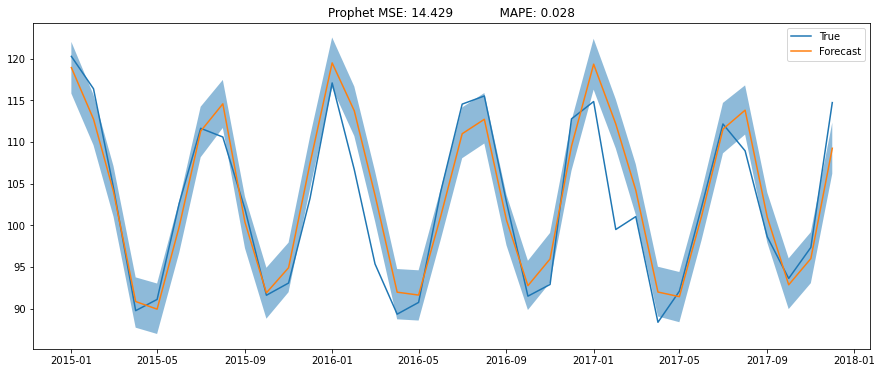

In [74]:
test['forecast'] = forecast.yhat.values
test['yhat_lower'] = forecast.yhat_lower.values
test['yhat_upper'] = forecast.yhat_upper.values

plt.figure(figsize=(15,6))
plt.plot(test.y, label='True')
plt.plot(test.forecast, label='Forecast')
plt.title(f'Prophet MSE: {round(mean_squared_error(test.y.values, test.forecast.values), 3)}\
            MAPE: {round(mape(test.y.values, test.forecast.values), 3)}')
plt.fill_between(test.index, test['yhat_lower'], test['yhat_upper'], alpha=0.5)
plt.legend()
plt.show()

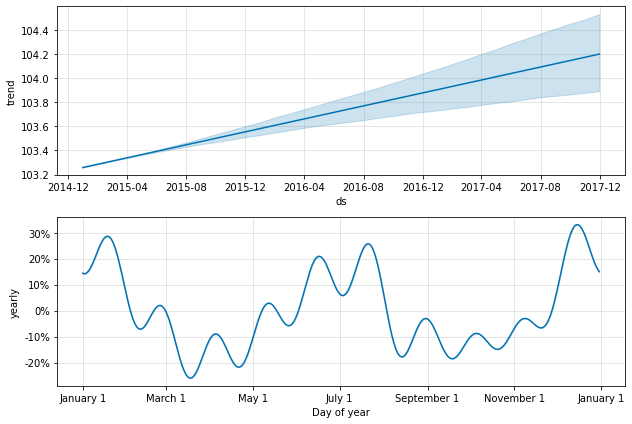

In [75]:
model.plot_components(forecast);

In [76]:
model = Prophet(seasonality_mode='multiplicative')
model.add_seasonality(name='year', period=12, fourier_order=3)
model.fit(train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


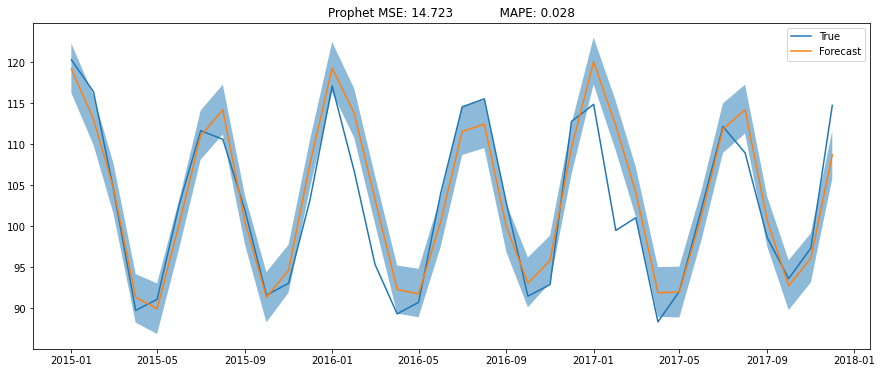

In [77]:
future = model.make_future_dataframe(periods=36, freq='M', include_history=False)
forecast = model.predict(future)

test['forecast'] = forecast.yhat.values
test['yhat_lower'] = forecast.yhat_lower.values
test['yhat_upper'] = forecast.yhat_upper.values

plt.figure(figsize=(15,6))
plt.plot(test.y, label='True')
plt.plot(test.forecast, label='Forecast')
plt.title(f'Prophet MSE: {round(mean_squared_error(test.y.values, test.forecast.values), 3)}\
            MAPE: {round(mape(test.y.values, test.forecast.values), 3)}')
plt.fill_between(test.index, test['yhat_lower'], test['yhat_upper'], alpha=0.5)
plt.legend()
plt.show()

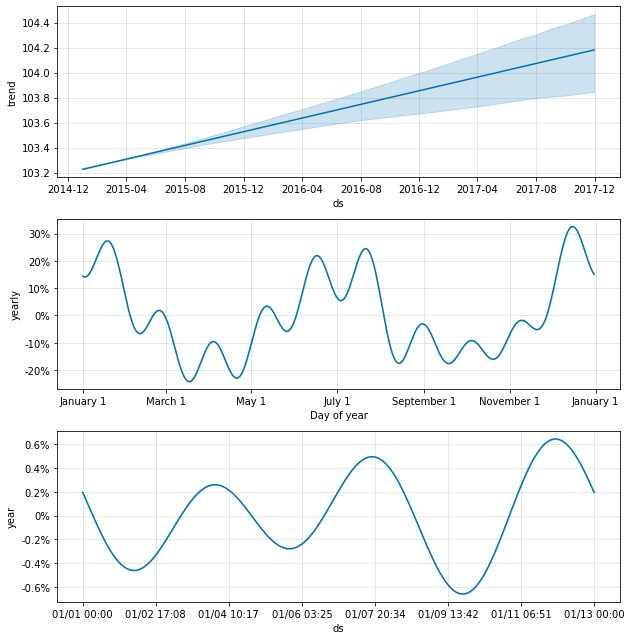

In [78]:
model.plot_components(forecast);

In [79]:
from fbprophet.diagnostics import cross_validation
model = Prophet(seasonality_mode='multiplicative')
model.fit(data_month)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [80]:
df_cv = cross_validation(model, horizon='1080 days')
df_cv.tail()

INFO:fbprophet:Making 15 forecasts with cutoffs between 1994-04-06 00:00:00 and 2014-12-17 00:00:00


ds        yhat  yhat_lower  yhat_upper         y     cutoff
528 2017-08-01  110.795134  107.937872  113.962804  108.9312 2014-12-17
529 2017-09-01  100.749839   97.702403  103.757856   98.6154 2014-12-17
530 2017-10-01   93.548161   90.527093   96.653522   93.6137 2014-12-17
531 2017-11-01   96.982839   93.846824  100.127270   97.3359 2014-12-17
532 2017-12-01  111.666524  108.496635  114.767234  114.7212 2014-12-17

In [81]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.tail()

horizon        mse      rmse       mae      mape     mdape  coverage
374 1070 days  11.539746  3.397020  2.584408  0.027037  0.021656  0.603774
375 1072 days  11.704936  3.421248  2.623979  0.027415  0.022208  0.584906
376 1076 days  11.988493  3.462440  2.674568  0.027998  0.022924  0.566038
377 1079 days  15.004109  3.873514  2.949243  0.030442  0.024659  0.547170
378 1080 days  15.178699  3.895985  3.001618  0.030892  0.025063  0.547170

In [82]:
df_p.mape.mean(), df_p.mse.mean()

(0.026691795489416432, 10.697670464767421)

In [83]:
model = Prophet(seasonality_mode='multiplicative', changepoints=['2008-01-01'])
model.fit(train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


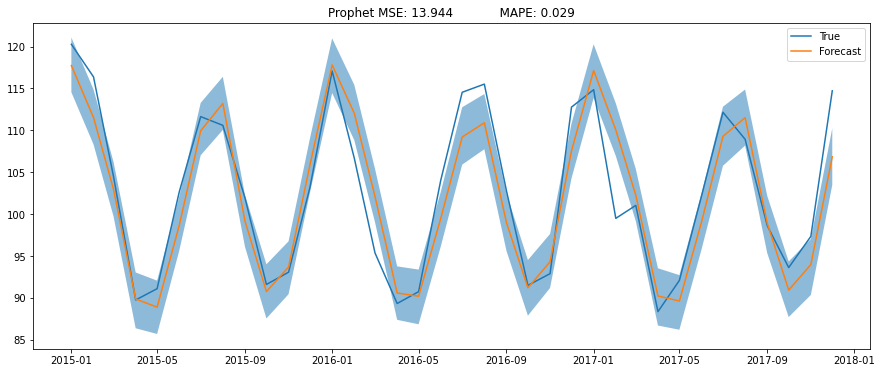

In [84]:
future = model.make_future_dataframe(periods=36, freq='M', include_history=False)
forecast = model.predict(future)

test['forecast'] = forecast.yhat.values
test['yhat_lower'] = forecast.yhat_lower.values
test['yhat_upper'] = forecast.yhat_upper.values

plt.figure(figsize=(15,6))
plt.plot(test.y, label='True')
plt.plot(test.forecast, label='Forecast')
plt.title(f'Prophet MSE: {round(mean_squared_error(test.y.values, test.forecast.values), 3)}\
            MAPE: {round(mape(test.y.values, test.forecast.values), 3)}')
plt.fill_between(test.index, test['yhat_lower'], test['yhat_upper'], alpha=0.5)
plt.legend()
plt.show()

### Vector Autoregression

In [85]:
df_mult = pd.read_table('occupancy_data/datatest2.txt', delimiter=',', header=0, parse_dates=True)
df_mult = df_mult.set_index('date')
df_mult = df_mult[['Temperature', 'Humidity', 'CO2', 'HumidityRatio']]
df_mult.shape

(9752, 4)

In [86]:
df_mult.head()

Temperature   Humidity          CO2  HumidityRatio
date                                                                   
2015-02-11 14:48:00      21.7600  31.133333  1029.666667       0.005021
2015-02-11 14:49:00      21.7900  31.000000  1000.000000       0.005009
2015-02-11 14:50:00      21.7675  31.122500  1003.750000       0.005022
2015-02-11 14:51:00      21.7675  31.122500  1009.500000       0.005022
2015-02-11 14:51:59      21.7900  31.133333  1005.666667       0.005030

In [87]:
df_mult.index.min(), df_mult.index.max()

('2015-02-11 14:48:00', '2015-02-18 09:19:00')

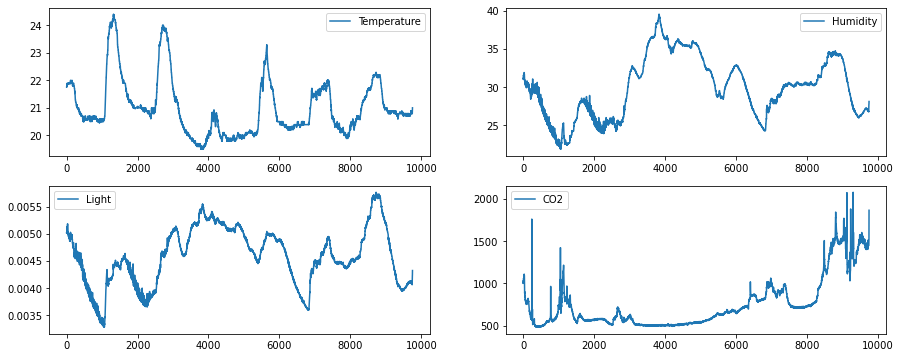

In [88]:
fig, ax = plt.subplots(2, 2, figsize=(15,6))
ax[0][0].plot(df_mult['Temperature'].values, label='Temperature')
ax[0][0].legend()
ax[0][1].plot(df_mult['Humidity'].values, label='Humidity')
ax[0][1].legend()
ax[1][0].plot(df_mult['HumidityRatio'].values, label='Light')
ax[1][0].legend()
ax[1][1].plot(df_mult['CO2'].values, label='CO2')
ax[1][1].legend()
plt.show()

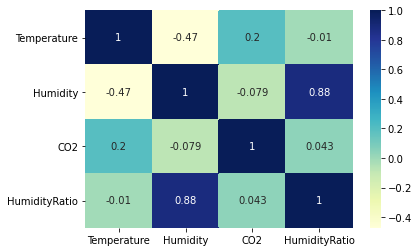

In [89]:
sns.heatmap(df_mult.corr(), cmap="YlGnBu", annot=True);

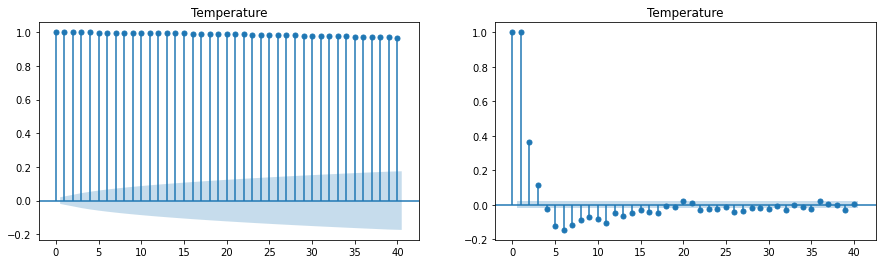

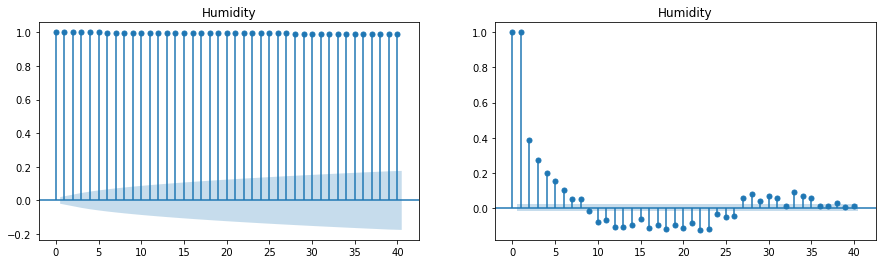

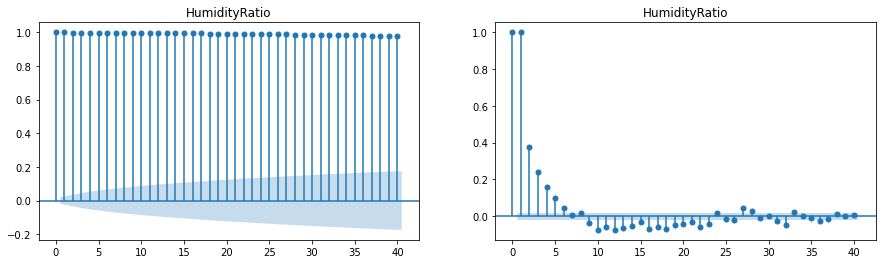

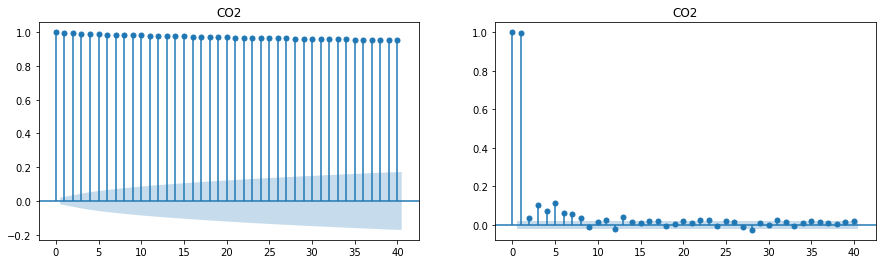

In [90]:
for i in ['Temperature', 'Humidity', 'HumidityRatio', 'CO2']:
    fig, ax = plt.subplots(1, 2, figsize=(15,4))
    plot_acf(df_mult[i], title=i, ax=ax[0]);
    plot_pacf(df_mult[i], title=i, ax=ax[1]);

In [91]:
def adf_test(time_series):
    res = adfuller(time_series)
    return round(res[1], 3)

for i in ['Temperature', 'Humidity', 'HumidityRatio', 'CO2']:
    print(f'{i} pvalue: {adf_test(df_mult[i])}')

Temperature pvalue: 0.018
Humidity pvalue: 0.433
HumidityRatio pvalue: 0.169
CO2 pvalue: 0.895


In [92]:
obs_n = 10
X_train, X_test = df_mult[9000:-obs_n], df_mult[-obs_n:]
len(X_train), len(X_test)

(742, 10)

In [93]:
X_train_log = np.log(X_train)
X_train_log_diff =(X_train_log).diff().dropna()

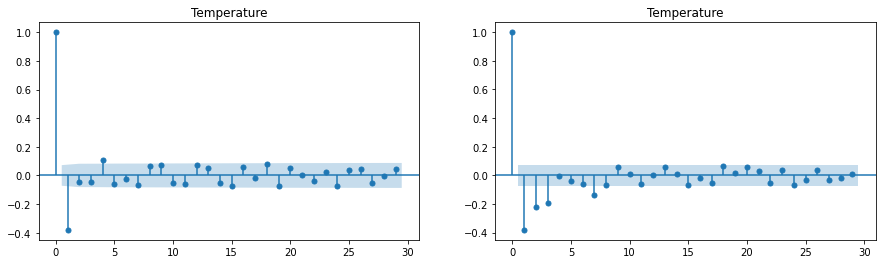

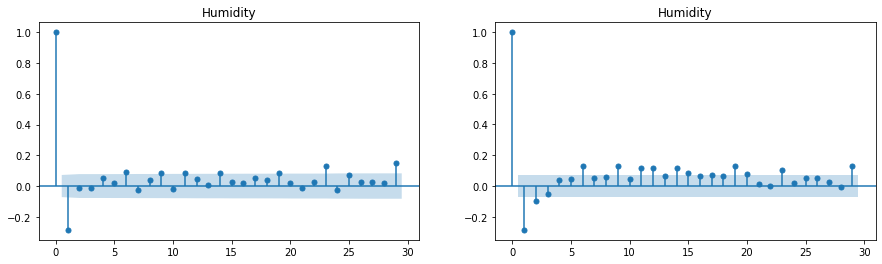

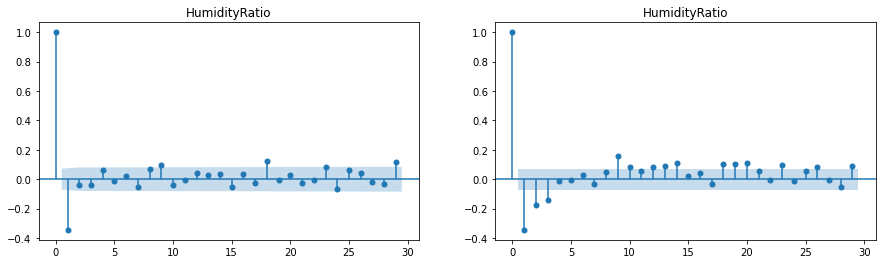

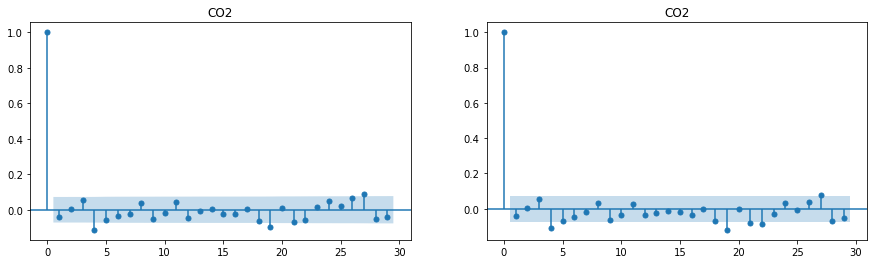

In [94]:
for i in ['Temperature', 'Humidity', 'HumidityRatio', 'CO2']:
    fig, ax = plt.subplots(1, 2, figsize=(15,4))
    plot_acf(X_train_log_diff[i], title=i, ax=ax[0]);
    plot_pacf(X_train_log_diff[i], title=i, ax=ax[1]);

In [95]:
for i in ['Temperature', 'Humidity', 'HumidityRatio', 'CO2']:
    print(f'{i} pvalue: {adf_test(X_train_log_diff[i])}')

Temperature pvalue: 0.0
Humidity pvalue: 0.192
HumidityRatio pvalue: 0.056
CO2 pvalue: 0.0


In [96]:
from statsmodels.tsa.api import VAR
model = VAR(endog=X_train_log_diff)
res = model.select_order(20)
res.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

In [97]:
model_fit = model.fit(maxlags=5)
# model_fit.summary()

In [98]:
lag_order = model_fit.k_ar
input_data = X_train_log_diff.values[-lag_order:]
pred = model_fit.forecast(y=input_data, steps=obs_n)
pred = (pd.DataFrame(pred, index=X_test.index, columns=X_test.columns))
pred.head()

Temperature  Humidity       CO2  HumidityRatio
date                                                               
2015-02-18 09:10:00     0.000258  0.000166 -0.003823       0.000499
2015-02-18 09:10:59     0.000285 -0.000074  0.003982       0.000292
2015-02-18 09:11:59    -0.000227 -0.000302 -0.003471      -0.000596
2015-02-18 09:13:00     0.000031 -0.000347  0.001084      -0.000310
2015-02-18 09:14:00    -0.000049 -0.000377  0.000308      -0.000442

In [99]:
for i in pred.columns:
    temp = pred[i]
    temp.iat[0] = np.log(X_test[i].iat[0])
    pred[i] = np.exp(temp.cumsum()).values
    
pred.head()

Temperature   Humidity          CO2  HumidityRatio
date                                                                   
2015-02-18 09:10:00    20.790000  26.745000  1463.750000       0.004058
2015-02-18 09:10:59    20.795933  26.743017  1469.590832       0.004059
2015-02-18 09:11:59    20.791214  26.734942  1464.499392       0.004057
2015-02-18 09:13:00    20.791866  26.725664  1466.087502       0.004055
2015-02-18 09:14:00    20.790849  26.715601  1466.538857       0.004054

In [100]:
assert len(X_test) == len(pred)

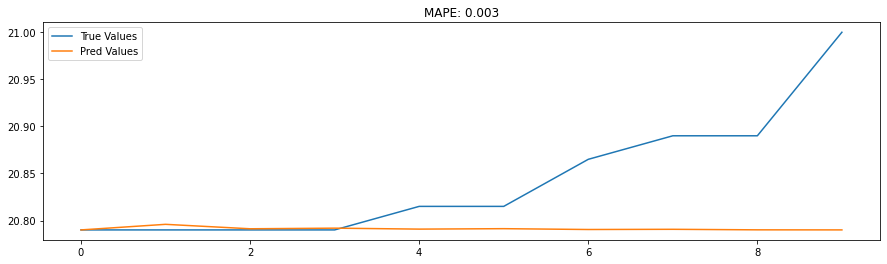

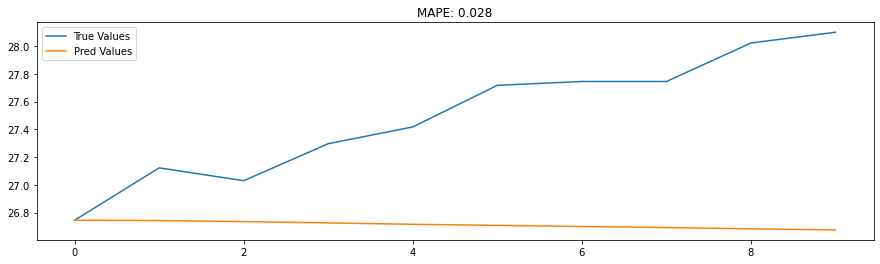

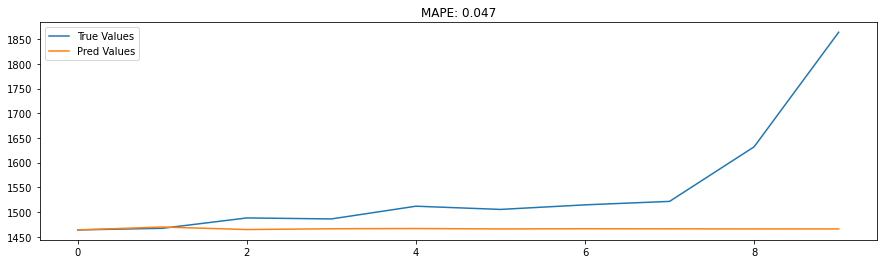

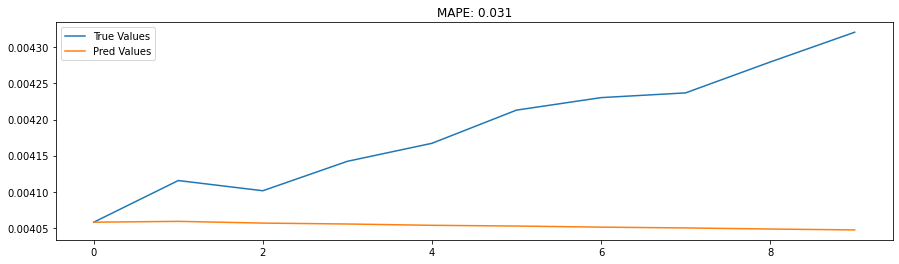

In [101]:
for i in X_test.columns:
    plt.figure(figsize=(15,4))
    plt.plot(X_test[i].values, label='True Values')
    plt.plot(pred[i].values, label='Pred Values')
    plt.title(f'MAPE: {round(mape(X_test[i].values, pred[i].values), 3)}')
    plt.legend()
    plt.show()